Install and Import

In [31]:
!pip install tensorflow pandas numpy matplotlib scikit-learn imbalanced-learn seaborn tabulate

In [35]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras import Input, Model
from tensorflow.keras.layers import (
    LSTM, Dense, Dropout, MultiHeadAttention, LayerNormalization, Flatten
)
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

from sklearn.metrics import precision_score, recall_score, f1_score

from tabulate import tabulate


Load Data

In [3]:
assessments = pd.read_csv('/content/drive/MyDrive/FYP/Dataset/OULAD/assessments.csv')
student_assessment = pd.read_csv('/content/drive/MyDrive/FYP/Dataset/OULAD/studentAssessment.csv')
student_info = pd.read_csv('/content/drive/MyDrive/FYP/Dataset/OULAD/studentInfo.csv')
vle = pd.read_csv('/content/drive/MyDrive/FYP/Dataset/OULAD/vle.csv')

# Handle potential bad lines in studentVle.csv
bad_line_count = 0
def bad_line_handler(line, line_number):
    global bad_line_count
    bad_line_count += 1
    print(f"Skipping line {line_number}: {line}")
    return None

student_vle = pd.read_csv(
    '/content/drive/MyDrive/FYP/Dataset/OULAD/studentVle.csv',
    engine='python',
    on_bad_lines=bad_line_handler
)
print(f"[Info] Number of bad lines skipped: {bad_line_count}")

[Info] Number of bad lines skipped: 0


In [4]:
# Data
data = [
    ["student_assessment", student_assessment.columns.tolist()],
    ["assessments", assessments.columns.tolist()],
    ["student_info", student_info.columns.tolist()],
    ["vle", vle.columns.tolist()],
    ["student_vle", student_vle.columns.tolist()]
]

# Print table
print(tabulate(data, headers=["Table", "Columns"], tablefmt="pretty"))

+--------------------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|       Table        |                                                                                           Columns                                                                                            |
+--------------------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| student_assessment |                                                           ['id_assessment', 'id_student', 'date_submitted', 'is_banked', 'score']                                                            |
|    assessments     |                                                  ['code_module', 'code_presentation', 'id_assessment', 'assessment_type',

Merge & Basic Cleaning

In [5]:
# Compute daily click volume for each student
vle_daily = student_vle.groupby(['id_student', 'date'])['sum_click'].sum().reset_index()

# Normalize 'date' as % of course duration (270 days total)
vle_daily['normalized_day'] = vle_daily['date'] / 270.0

In [6]:
# Merge student_assessment with student_info & assessments
student_data = pd.merge(student_assessment, student_info, on='id_student', how='left')
student_data = pd.merge(student_data, assessments, on='id_assessment', how='left')
# Merge daily click volume with student data
student_data = pd.merge(student_data, vle_daily, on=['id_student'], how='left')

# Fill NaN values (some students may not have click data every day)
student_data['sum_click'] = student_data['sum_click'].fillna(0)

# Drop invalid date_submitted
student_data = student_data.dropna(subset=['date_submitted'])
student_data = student_data[student_data['date_submitted'] > 0]

# Normalize date_submitted [0..1] => /270
student_data['normalized_date'] = student_data['date_submitted'] / 270.0

# Convert final_result
student_data['final_result'] = student_data['final_result'].replace({
    'Distinction': 3, 'Pass': 2, 'Fail': 1, 'Withdrawn': 0
})

<ipython-input-6-18dde419567c>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  student_data['normalized_date'] = student_data['date_submitted'] / 270.0
<ipython-input-6-18dde419567c>:18: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  student_data['final_result'] = student_data['final_result'].replace({


Weekly Average Click Volume by Segment

In [7]:
# Create "normalized_day" in student_vle => day/270
student_vle['normalized_day'] = student_vle['date'] / 270.0

In [8]:
#Define function to label each row with segment (0..4)
def assign_segment(x):
    if x <= 0.2:
        return 0
    elif x <= 0.4:
        return 1
    elif x <= 0.6:
        return 2
    elif x <= 0.8:
        return 3
    else:
        return 4

student_vle['segment'] = student_vle['normalized_day'].apply(assign_segment)


In [9]:
# Derive 'week' from 'date'
# Assuming the course starts on day 0 and each week has 7 days
student_vle['week'] = (student_vle['date'] // 7) + 1  # Add 1 to make weeks start from 1 instead of 0

# Now you can group by 'week'
vle_segment_week = student_vle.groupby(
    ['id_student', 'code_module', 'code_presentation', 'segment', 'week']
)['sum_click'].sum().reset_index()

In [10]:
# Summarize weekly average click volume per (student, segment)
# VLE data has 'sum_click' for each (student, date, id_site).
# group by (id_student, code_module, code_presentation, segment, week) => sum of clicks that week
vle_segment_week = student_vle.groupby(
    ['id_student','code_module','code_presentation','segment','week']
)['sum_click'].sum().reset_index()

In [11]:
# for each (id_student, code_module, code_presentation, segment), compute the *average* of sum_click across weeks
vle_segment_avg = vle_segment_week.groupby(
    ['id_student','code_module','code_presentation','segment']
)['sum_click'].mean().reset_index(name='weekly_avg_click_volume')

# This is the "weekly average click volume for each segment," as the paper describes.

Aggregate Scores & Summaries at Segment Level


> We'll also do the same approach in "student_data" to find average score per segment. Actually, we already have a normalized_date in 'student_data' => define segment the same way

In [12]:
student_data['segment'] = student_data['normalized_date'].apply(assign_segment)

In [13]:
print(f"student data head: {student_data.columns}")

student data head: Index(['id_assessment', 'id_student', 'date_submitted', 'is_banked', 'score',
       'code_module_x', 'code_presentation_x', 'gender', 'region',
       'highest_education', 'imd_band', 'age_band', 'num_of_prev_attempts',
       'studied_credits', 'disability', 'final_result', 'code_module_y',
       'code_presentation_y', 'assessment_type', 'date_x', 'weight', 'date_y',
       'sum_click', 'normalized_day', 'normalized_date', 'segment'],
      dtype='object')


In [14]:
# Drop duplicate columns
student_data = student_data.drop(columns=['code_module_y', 'code_presentation_y'])

# Rename the remaining columns
student_data = student_data.rename(columns={'code_module_x': 'code_module', 'code_presentation_x': 'code_presentation'})

In [15]:
# For each (id_student, code_module, code_presentation, segment), compute average score
score_agg = student_data.groupby(
    ['id_student','code_module','code_presentation','segment']
)['score'].mean().reset_index(name='avg_score_segment')

In [16]:
# Additionally, we can count how many assessments in that segment
count_agg = student_data.groupby(
    ['id_student','code_module','code_presentation','segment']
)['id_assessment'].count().reset_index(name='num_assessments_segment')

Merge All Segment Summaries



> We'll combine weekly_avg_click_volume + avg_score_segment + num_assessments_segment



In [17]:
summary_seg = pd.merge(vle_segment_avg, score_agg,
                       on=['id_student','code_module','code_presentation','segment'],
                       how='outer')
summary_seg = pd.merge(summary_seg, count_agg,
                       on=['id_student','code_module','code_presentation','segment'],
                       how='outer').fillna(0)
summary_seg = pd.merge(summary_seg, vle_daily[['id_student', 'sum_click']],
                       on=['id_student'], how='left')


In [18]:
# is sum_click has missing values fill
summary_seg['sum_click'] = summary_seg['sum_click'].fillna(0)

In [19]:
summary_seg['avg_score_segment'] = summary_seg['avg_score_segment'].fillna(0)
summary_seg['num_assessments_segment'] = summary_seg['num_assessments_segment'].fillna(0)

> Now we have a table with columns:

['id_student','code_module','code_presentation','segment','weekly_avg_click_volume','avg_score_segment','num_assessments_segment']
> We'll also bring in final_result & demographics from student_info




In [20]:
static_cols = [
    'id_student','code_module','code_presentation','gender','region',
    'highest_education','imd_band','age_band','disability','final_result'
]
static_data = student_data[static_cols].drop_duplicates(
    subset=['id_student','code_module','code_presentation']
)

full_segments = pd.merge(summary_seg, static_data,
                         on=['id_student','code_module','code_presentation'],
                         how='left').fillna(0)


In [21]:
print("[Debug] Columns in full_segments after merge:", full_segments.columns.tolist())

[Debug] Columns in full_segments after merge: ['id_student', 'code_module', 'code_presentation', 'segment', 'weekly_avg_click_volume', 'avg_score_segment', 'num_assessments_segment', 'sum_click', 'gender', 'region', 'highest_education', 'imd_band', 'age_band', 'disability', 'final_result']


Encode Categorical & Scale

In [22]:
cat_cols = ['gender','region','highest_education','imd_band','age_band','disability']
for c in cat_cols:
    full_segments[c] = full_segments[c].astype(str)
    le = LabelEncoder()
    full_segments[c] = le.fit_transform(full_segments[c])

In [23]:
# scale weekly_avg_click_volume & avg_score_segment if desired
scaler1 = MinMaxScaler()
full_segments[['weekly_avg_click_volume','avg_score_segment','num_assessments_segment', 'sum_click']] = \
    scaler1.fit_transform(full_segments[['weekly_avg_click_volume','avg_score_segment','num_assessments_segment', 'sum_click']])

In [24]:
print("[Debug] Columns in full_segments after merge:", full_segments.columns.tolist())

[Debug] Columns in full_segments after merge: ['id_student', 'code_module', 'code_presentation', 'segment', 'weekly_avg_click_volume', 'avg_score_segment', 'num_assessments_segment', 'sum_click', 'gender', 'region', 'highest_education', 'imd_band', 'age_band', 'disability', 'final_result']


Reindex so each student has segments [0..4]

In [25]:
all_segments = []
for (sid, cm, cp), subdf in full_segments.groupby(['id_student','code_module','code_presentation']):
    subdf = subdf.drop_duplicates(subset=['segment'], keep='first')
    subdf = subdf.set_index('segment').sort_index()

    # ensure segments 0..4 exist
    subdf = subdf.reindex(range(5), fill_value=0)
    subdf['id_student'] = sid
    subdf['code_module'] = cm
    subdf['code_presentation'] = cp
    all_segments.append(subdf.reset_index())

final_segments = pd.concat(all_segments, ignore_index=True)

selected_features = [
    'id_student', 'code_module', 'code_presentation', 'segment',
    'weekly_avg_click_volume', 'avg_score_segment', 'num_assessments_segment', 'sum_click',
    'gender', 'region', 'highest_education', 'imd_band', 'age_band', 'disability',
    'final_result'
]

final_segments = final_segments[selected_features]

In [26]:
print("[Info] Final dataset shape:", final_segments.shape)
print("[Info] Columns in final dataset:", final_segments.columns.tolist())

[Info] Final dataset shape: (148145, 15)
[Info] Columns in final dataset: ['id_student', 'code_module', 'code_presentation', 'segment', 'weekly_avg_click_volume', 'avg_score_segment', 'num_assessments_segment', 'sum_click', 'gender', 'region', 'highest_education', 'imd_band', 'age_band', 'disability', 'final_result']


Build 3D array (N, 5, F)

In [27]:
# For final_result, we'll map each student-> final_result
label_map = {}
for idx, row in static_data.iterrows():
    s_id = row['id_student']
    s_res = row['final_result']
    label_map[s_id] = s_res

In [28]:
# choose which features go into each segment's vector
feature_cols = [
    'weekly_avg_click_volume','avg_score_segment','num_assessments_segment',
    'gender','region','highest_education','imd_band','age_band','disability',
    'sum_click'
]


In [29]:
print("[Debug] Available columns in subdf:", subdf.columns.tolist())

[Debug] Available columns in subdf: ['id_student', 'code_module', 'code_presentation', 'weekly_avg_click_volume', 'avg_score_segment', 'num_assessments_segment', 'sum_click', 'gender', 'region', 'highest_education', 'imd_band', 'age_band', 'disability', 'final_result']


In [30]:
X_list, y_list, student_ids = [], [], []
for (sid, cm, cp), subdf in final_segments.groupby(['id_student','code_module','code_presentation']):
    subdf = subdf.sort_values('segment')
    # build time-sequence shape (5, F)
    seq = subdf[feature_cols].values
    # final_result is the same for all segments => get from label_map or from subdf
    fr = label_map.get(sid, None)
    if fr is None:
        # missing label
        continue
    X_list.append(seq)
    y_list.append(fr)
    student_ids.append(sid)

X_full = np.array(X_list)  # shape (N,5,F)
y_full = np.array(y_list)
print("[Info] X_full shape:", X_full.shape, " y_full shape:", y_full.shape)


[Info] X_full shape: (26675, 5, 10)  y_full shape: (26675,)


Check what over sampling method should suitable

Class distribution:
 final_result
2.0    61250
0.0    51856
1.0    20010
3.0    15029
Name: count, dtype: int64


<ipython-input-31-e1147f596fcf>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_counts.index, y=class_counts.values, palette="Blues")


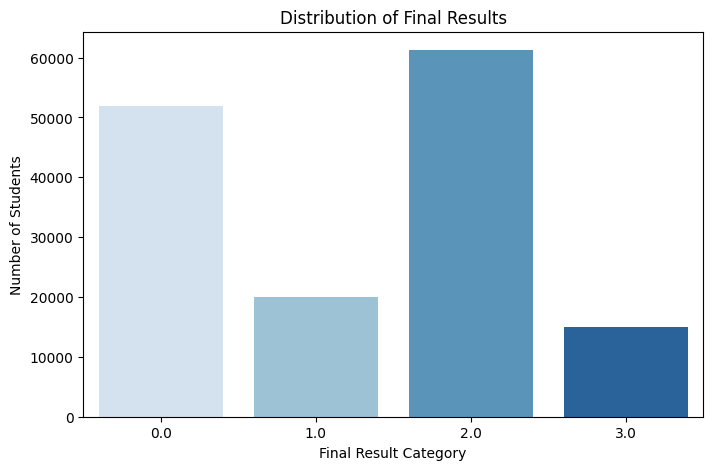

In [31]:
# Check class distribution
class_counts = final_segments['final_result'].value_counts()
print("Class distribution:\n", class_counts)

# Plot class distribution
plt.figure(figsize=(8,5))
sns.barplot(x=class_counts.index, y=class_counts.values, palette="Blues")
plt.xlabel("Final Result Category")
plt.ylabel("Number of Students")
plt.title("Distribution of Final Results")
plt.show()

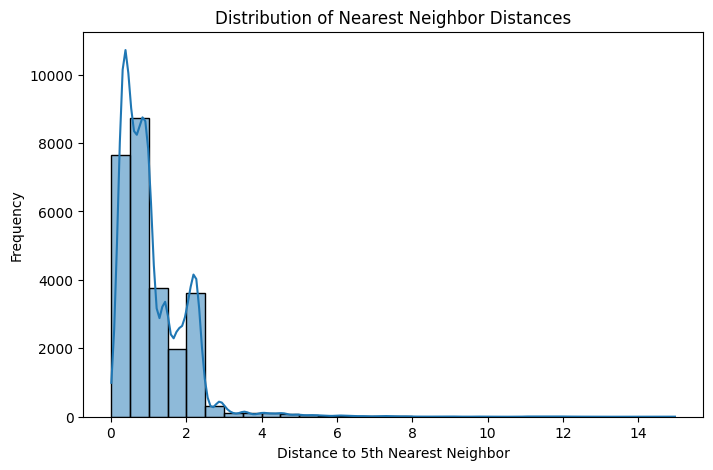

In [32]:
from sklearn.neighbors import NearestNeighbors

# Fit a Nearest Neighbors model on the feature space
X_check = X_full.reshape(X_full.shape[0], -1)  # Flatten for analysis
neigh = NearestNeighbors(n_neighbors=5)
neigh.fit(X_check)

# Compute distances to nearest neighbors
distances, _ = neigh.kneighbors(X_check)

# Plot the distribution of distances to the 5th nearest neighbor
plt.figure(figsize=(8,5))
sns.histplot(distances[:, -1], bins=30, kde=True)
plt.xlabel("Distance to 5th Nearest Neighbor")
plt.ylabel("Frequency")
plt.title("Distribution of Nearest Neighbor Distances")
plt.show()


Handle Class Imbalance

In [38]:
from imblearn.combine import SMOTETomek

In [39]:
N, T, Fdim = X_full.shape
X_flat = X_full.reshape(N, -1)  # flatten for SMOTETomek

# Apply SMOTETomek (Hybrid Oversampling + Undersampling)
smote_tomek = SMOTETomek(random_state=42)
X_resampled, y_resampled = smote_tomek.fit_resample(X_flat, y_full)

# Reshape for LSTM
X_resampled = X_resampled.reshape(X_resampled.shape[0], T, Fdim)
print("[Info] Final Balanced Dataset Shape:", X_resampled.shape, y_resampled.shape)



[Info] Final Balanced Dataset Shape: (50740, 5, 10) (50740,)


In [33]:
# from imblearn.combine import SMOTEENN

# # Extract dimensions for reshaping
# N, T, Fdim = X_full.shape

# # Flatten for SMOTE-ENN processing
# X_flat = X_full.reshape(N, -1)

# # Apply SMOTE-ENN (Hybrid Oversampling + Noise Cleaning)
# smote_enn = SMOTEENN(random_state=42)
# X_resampled, y_resampled = smote_enn.fit_resample(X_flat, y_full)

# # Reshape back for LSTM model training
# X_resampled = X_resampled.reshape(X_resampled.shape[0], T, Fdim)

# # Display final dataset shape
# print("[✅ Info] Final Balanced Dataset Shape:", X_resampled.shape, y_resampled.shape)


[✅ Info] Final Balanced Dataset Shape: (30851, 5, 10) (30851,)


In [37]:
# from imblearn.over_sampling import SMOTE

# # Extract dimensions for reshaping
# N, T, Fdim = X_full.shape

# # Flatten for SMOTE-ENN processing
# X_flat = X_full.reshape(N, -1)

# # Apply SMOTE-ENN (Hybrid Oversampling + Noise Cleaning)
# smote_enn = SMOTE(random_state=42)
# X_resampled, y_resampled = smote_enn.fit_resample(X_flat, y_full)

# # Reshape back for LSTM model training
# X_resampled = X_resampled.reshape(X_resampled.shape[0], T, Fdim)

# # Display final dataset shape
# print("[✅ Info] Final Balanced Dataset Shape:", X_resampled.shape, y_resampled.shape)

[✅ Info] Final Balanced Dataset Shape: (53220, 5, 10) (53220,)


Save preprocessed dataset in drive then run from below

In [40]:
# Define file path in Google Drive
output_path = "/content/drive/MyDrive/FYP/Dataset/trained/processed_data-v7.npz"

# Save X and y arrays to Google Drive
np.savez_compressed(output_path, X_resampled=X_resampled, y_resampled=y_resampled)

print(f"[✅] Processed dataset saved to: {output_path}")

[✅] Processed dataset saved to: /content/drive/MyDrive/FYP/Dataset/trained/processed_data-v7.npz


In [1]:
from google.colab import drive
import numpy as np

# Load the saved dataset
input_path = "/content/drive/MyDrive/FYP/Dataset/trained/processed_data-v7.npz"
data = np.load(input_path)

# Assign loaded arrays
X_resampled = data['X_resampled']
y_resampled = data['y_resampled']

print(f"[✅] Loaded dataset from: {input_path}")
print(f"[Info] X_resampled shape: {X_resampled.shape}, y_resampled shape: {y_resampled.shape}")

[✅] Loaded dataset from: /content/drive/MyDrive/FYP/Dataset/trained/processed_data-v7.npz
[Info] X_resampled shape: (50740, 5, 10), y_resampled shape: (50740,)


Multiple Early Prediction Models

The paper tests model performance after 20%, 40%, 60%, 80%, 100% of the course
=> we train 5 separate models:
    Model_1 uses the first 1 segment (T=1)
    Model_2 uses the first 2 segments (T=2)
    ...
    Model_5 uses all 5 segments (T=5)


In [ ]:
# def build_mtaps_model(n_segments, n_features):
#     """
#     Build 3-layer LSTM + Multi-head attention + Dense (ANN) model.
#     """
#     inputs = Input(shape=(n_segments, n_features))
#     x = LSTM(64, return_sequences=True)(inputs)
#     x = LSTM(64, return_sequences=True)(x)
#     x = LSTM(64, return_sequences=True)(x)

#     attn_output = MultiHeadAttention(num_heads=4, key_dim=32)(x, x, x)
#     x = x + attn_output
#     x = LayerNormalization()(x)

#     # optional: a feedforward block or dropout
#     # x = Dense(64, activation='relu')(x)
#     # x = Dropout(0.2)(x)

#     x = Flatten()(x)
#     x = Dense(64, activation='relu')(x)
#     x = Dense(32, activation='relu')(x)
#     outputs = Dense(4, activation='softmax')(x)

#     model = Model(inputs, outputs)
#     model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
#     return model


In [ ]:
# Multiple Early Prediction Models
# def build_mtaps_model(n_segments, n_features):
#     """
#     Build 3-layer LSTM + Multi-head attention + Dense (ANN) model.
#     """
#     inputs = Input(shape=(n_segments, n_features))
#     attn_output = MultiHeadAttention(num_heads=4, key_dim=32)(inputs, inputs, inputs)
#     attn_norm = LayerNormalization()(attn_output)

#     # Then pass through LSTMs
#     x = LSTM(64, return_sequences=True)(attn_norm)
#     x = LSTM(64, return_sequences=True)(x)
#     x = LSTM(64, return_sequences=True)(x)

#     x = Flatten()(x)
#     x = Dense(64, activation='relu')(x)
#     x = Dense(32, activation='relu')(x)

#     outputs = Dense(4, activation='softmax')(x)

#     model = Model(inputs, outputs)
#     model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
#     return model

In [2]:
def plot_confusion_matrix(y_true, y_pred, labels, title):
    """
    Plots a confusion matrix using seaborn heatmap.
    """
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(title)
    plt.show()

In [10]:
def build_mtaps_model(n_segments, n_features):
    """
    Multi-Class Classification Model (4-class: Withdrawn, Fail, Pass, Distinction),
    Build a 3-layer LSTM + Multi-head self-attention + Dense (ANN) model.
    Corrected architecture: LSTM ➝ MHSA ➝ ANN
    """
    inputs = Input(shape=(n_segments, n_features))

    # Step 1: Pass input through 3-layer LSTM (with 64 units per layer)
    x = LSTM(64, return_sequences=True)(inputs)
    x = Dropout(0.2)(x)
    x = LSTM(64, return_sequences=True)(x)
    x = Dropout(0.2)(x)
    x = LSTM(64, return_sequences=True)(x)

    # Step 2: Apply Multi-Head Self-Attention AFTER LSTM layers
    attn_output = MultiHeadAttention(num_heads=4, key_dim=32)(x, x, x)
    # attn_norm = LayerNormalization()(attn_output)
    attn_norm = LayerNormalization()(x + attn_output)  # Residual Connection

    # Step 3: Flatten and pass through ANN layers
    x = Flatten()(attn_norm)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.2)(x)
    x = Dense(32, activation='relu')(x)
    x = Dropout(0.2)(x)

    #Multi-Class Output Layer (4 classes)
    outputs = Dense(4, activation='softmax')(x)  # 4-class classification

    model = Model(inputs, outputs)
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

print("[Info] Model architecture : LSTM ➝ MHSA ➝ ANN ")

[Info] Model architecture : LSTM ➝ MHSA ➝ ANN 


In [6]:
def build_mtaps_binary_model(n_segments, n_features):
    """
    Binary Classification Model (WF-PD, F-PD, W-PD)
    Uses Sigmoid Activation & Binary Crossentropy Loss
    """
    inputs = Input(shape=(n_segments, n_features))

    # LSTM Layers
    x = LSTM(64, return_sequences=True)(inputs)
    x = LSTM(64, return_sequences=True)(x)
    x = LSTM(64, return_sequences=True)(x)

    # Multi-Head Self-Attention
    attn_output = MultiHeadAttention(num_heads=4, key_dim=32)(x, x, x)
    attn_norm = LayerNormalization()(attn_output)

    # Flatten and Dense Layers
    x = Flatten()(attn_norm)
    x = Dense(64, activation='relu')(x)
    x = Dense(32, activation='relu')(x)

    # Binary Output Layer (1 class)
    outputs = Dense(1, activation='sigmoid')(x)  # Sigmoid for binary classification

    model = Model(inputs, outputs)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    return model

In [17]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    monitor='val_loss',      # Monitor validation loss
    patience=20,              # Stop if val_loss doesn't improve for 15 epochs
    restore_best_weights=True  # Restore best model weights
)

In [19]:
def train_early_model(X_data, y_data, segments_used, epochs=50, test_size=0.2, random_state=42, is_binary=False):
    """
    Slices the first `segments_used` from the full 5.
    Builds and trains a model. Returns (model, (X_test, y_test)).
    """
    # X_data shape: (N,5,F)
    # print(f"[Debug] X_data shape: {X_data.shape}, y_data shape: {y_data.shape}")

    # Slice
    X_sliced = X_data[:, :segments_used, :]
    # print(f"[Debug] X_sliced shape (after segment selection): {X_sliced.shape}")

    # Train/test split
    X_train, X_test, y_train, y_test = train_test_split(
        X_sliced, y_data, test_size=test_size, stratify=y_data, random_state=random_state
    )

    # print(f"[Debug] X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
    # print(f"[Debug] X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

    # Select appropriate model
    if is_binary:
        print("[Info] Binary Classification Model")
        model = build_mtaps_binary_model(segments_used, X_sliced.shape[2])  # Use Binary Model
    else:
        print("[Info] Multi-Class Classification Model")
        model = build_mtaps_model(segments_used, X_sliced.shape[2])  # Use Multi-Class Model


    print(f"[Info] Training Model for {segments_used} segments => {segments_used*20}% of course")

    #train model
    history = model.fit(
        X_train, y_train,
        epochs=epochs,
        batch_size=64,
        validation_split=0.1,
        callbacks=[early_stopping],
        verbose=1
    )

    print(f"[Info] Model train completed... Evaluate start")

    # Evaluate
    test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
    print(f"Test Accuracy with first {segments_used} segments: {test_acc:.4f}")

    # Classification report
    y_pred_probs = model.predict(X_test)

    # Adjust predictions based on classification type
    if is_binary:
        y_pred = (y_pred_probs > 0.5).astype(int)  # Convert to binary labels
        # target_names = ['Class 0', 'Class 1']
        # Assign correct labels based on task
        if len(np.unique(y_data)) == 2:  # Only two classes in binary
            if set(y_data) == {0, 1}:  # Generic binary case
                target_names = ['Fail', 'Pass']
            else:
                target_names = ['Withdrawn/Fail', 'Pass/Distinction']  # Modify based on task
        else:
            target_names = ['Class 0', 'Class 1']  # Default fallback
    else:
        y_pred = np.argmax(y_pred_probs, axis=1)  # Multi-class classification
        target_names = ['Withdrawn', 'Fail', 'Pass', 'Distinction']

    # # If y_data contains only 0 and 1 (binary), use binary target names.
    # if len(np.unique(y_data)) == 2:
    #     target_names = ['Fail', 'Pass']
    # else:
    #     target_names = ['Withdrawn','Fail','Pass','Distinction']

    # target_names = ['Withdrawn','Fail','Pass','Distinction']
    print(classification_report(y_test, y_pred, target_names=target_names))

    # Plot Confusion Matrix
    plot_confusion_matrix(y_test, y_pred, labels=target_names, title=f"Confusion Matrix (Model {segments_used})")


    return model, (X_test, y_test)

[Info] Multi-Class Classification Model
[Info] Training Model for 1 segments => 20% of course
Epoch 1/50
571/571 ━━━━━━━━━━━━━━━━━━━━ 59s 15ms/step - accuracy: 0.2968 - loss: 1.3613 - val_accuracy: 0.4106 - val_loss: 1.2020
Epoch 2/50
571/571 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - accuracy: 0.4073 - loss: 1.2204 - val_accuracy: 0.4219 - val_loss: 1.1816
Epoch 3/50
571/571 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - accuracy: 0.4074 - loss: 1.1950 - val_accuracy: 0.4187 - val_loss: 1.1544
Epoch 4/50
571/571 ━━━━━━━━━━━━━━━━━━━━ 11s 13ms/step - accuracy: 0.4130 - loss: 1.1806 - val_accuracy: 0.4219 - val_loss: 1.1613
Epoch 5/50
571/571 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - accuracy: 0.4275 - loss: 1.1743 - val_accuracy: 0.4224 - val_loss: 1.1550
Epoch 6/50
571/571 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - accuracy: 0.4233 - loss: 1.1645 - val_accuracy: 0.4268 - val_loss: 1.1501
Epoch 7/50
571/571 ━━━━━━━━━━━━━━━━━━━━ 8s 13ms/step - accuracy: 0.4280 - loss: 1.1648 - val_accuracy: 0.4310 - val_loss: 1.1381

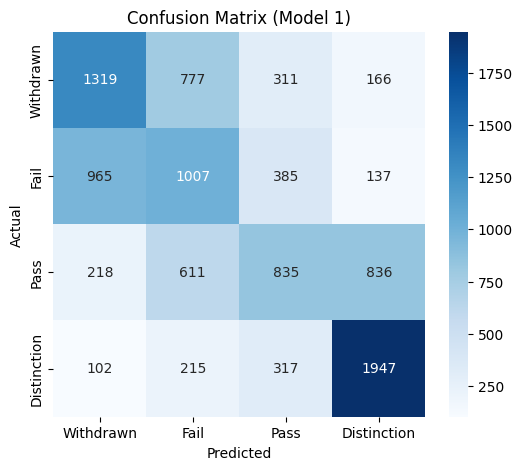

318/318 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

[Info] Model 1 - 20% Course Progress:
 Precision: 0.4950, Recall: 0.5034, F1-score: 0.4956
[Info] Multi-Class Classification Model
[Info] Training Model for 2 segments => 40% of course
Epoch 1/50
571/571 ━━━━━━━━━━━━━━━━━━━━ 13s 13ms/step - accuracy: 0.3347 - loss: 1.3153 - val_accuracy: 0.4951 - val_loss: 1.0932
Epoch 2/50
571/571 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - accuracy: 0.4686 - loss: 1.1228 - val_accuracy: 0.5182 - val_loss: 1.0497
Epoch 3/50
571/571 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - accuracy: 0.4840 - loss: 1.0900 - val_accuracy: 0.5165 - val_loss: 1.0319
Epoch 4/50
571/571 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - accuracy: 0.5018 - loss: 1.0661 - val_accuracy: 0.4818 - val_loss: 1.0610
Epoch 5/50
571/571 ━━━━━━━━━━━━━━━━━━━━ 8s 13ms/step - accuracy: 0.5026 - loss: 1.0526 - val_accuracy: 0.5261 - val_loss: 1.0205
Epoch 6/50
571/571 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - accuracy: 0.5058 - loss: 1.0491 - val_accuracy: 0.5310 - val_loss: 1.01

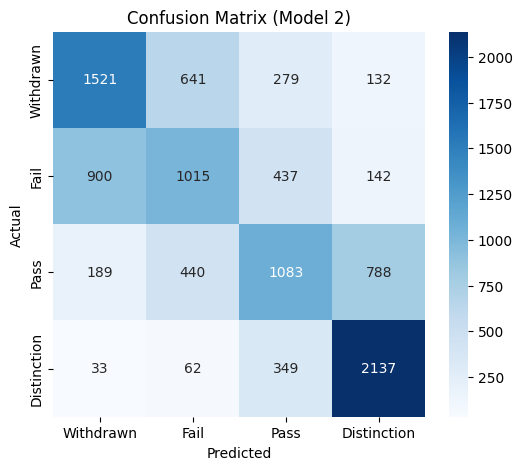

318/318 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step

[Info] Model 2 - 40% Course Progress:
 Precision: 0.5556, Recall: 0.5672, F1-score: 0.5580
[Info] Multi-Class Classification Model
[Info] Training Model for 3 segments => 60% of course
Epoch 1/50
571/571 ━━━━━━━━━━━━━━━━━━━━ 13s 15ms/step - accuracy: 0.3989 - loss: 1.2077 - val_accuracy: 0.5596 - val_loss: 0.9423
Epoch 2/50
571/571 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - accuracy: 0.5506 - loss: 0.9512 - val_accuracy: 0.5488 - val_loss: 0.9275
Epoch 3/50
571/571 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - accuracy: 0.5691 - loss: 0.9214 - val_accuracy: 0.5887 - val_loss: 0.9008
Epoch 4/50
571/571 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - accuracy: 0.5851 - loss: 0.9016 - val_accuracy: 0.5879 - val_loss: 0.8793
Epoch 5/50
571/571 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - accuracy: 0.5892 - loss: 0.8919 - val_accuracy: 0.5909 - val_loss: 0.8850
Epoch 6/50
571/571 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - accuracy: 0.5939 - loss: 0.8870 - val_accuracy: 0.5961 - val_loss: 0.88

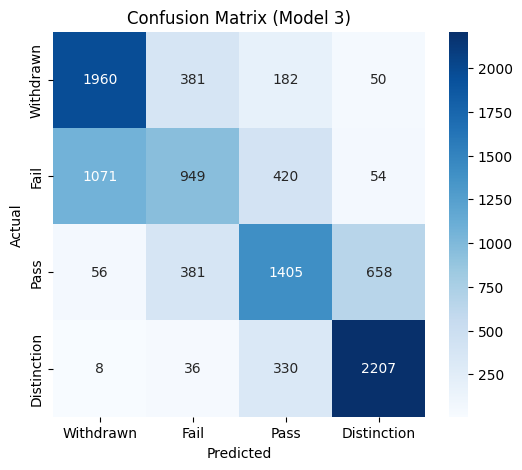

318/318 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step

[Info] Model 3 - 60% Course Progress:
 Precision: 0.6312, Recall: 0.6426, F1-score: 0.6307
[Info] Multi-Class Classification Model
[Info] Training Model for 4 segments => 80% of course
Epoch 1/50
571/571 ━━━━━━━━━━━━━━━━━━━━ 15s 15ms/step - accuracy: 0.4289 - loss: 1.1398 - val_accuracy: 0.5766 - val_loss: 0.8735
Epoch 2/50
571/571 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - accuracy: 0.5735 - loss: 0.8868 - val_accuracy: 0.5993 - val_loss: 0.8433
Epoch 3/50
571/571 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - accuracy: 0.5894 - loss: 0.8498 - val_accuracy: 0.6148 - val_loss: 0.8115
Epoch 4/50
571/571 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - accuracy: 0.6076 - loss: 0.8294 - val_accuracy: 0.6059 - val_loss: 0.8163
Epoch 5/50
571/571 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - accuracy: 0.6120 - loss: 0.8224 - val_accuracy: 0.6190 - val_loss: 0.8052
Epoch 6/50
571/571 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - accuracy: 0.6177 - loss: 0.8126 - val_accuracy: 0.6254 - val_loss: 0

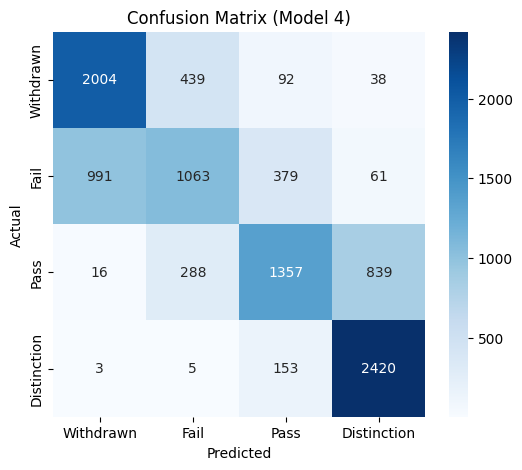

318/318 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step

[Info] Model 4 - 80% Course Progress:
 Precision: 0.6662, Recall: 0.6744, F1-score: 0.6602
[Info] Multi-Class Classification Model
[Info] Training Model for 5 segments => 100% of course
Epoch 1/50
571/571 ━━━━━━━━━━━━━━━━━━━━ 13s 15ms/step - accuracy: 0.4636 - loss: 1.0716 - val_accuracy: 0.5897 - val_loss: 0.8419
Epoch 2/50
571/571 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - accuracy: 0.5768 - loss: 0.8643 - val_accuracy: 0.5931 - val_loss: 0.8202
Epoch 3/50
571/571 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - accuracy: 0.5925 - loss: 0.8344 - val_accuracy: 0.5985 - val_loss: 0.8176
Epoch 4/50
571/571 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - accuracy: 0.5996 - loss: 0.8242 - val_accuracy: 0.6128 - val_loss: 0.7932
Epoch 5/50
571/571 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - accuracy: 0.6145 - loss: 0.7991 - val_accuracy: 0.6340 - val_loss: 0.7707
Epoch 6/50
571/571 ━━━━━━━━━━━━━━━━━━━━ 8s 13ms/step - accuracy: 0.6242 - loss: 0.7885 - val_accuracy: 0.6239 - val_loss: 0.76

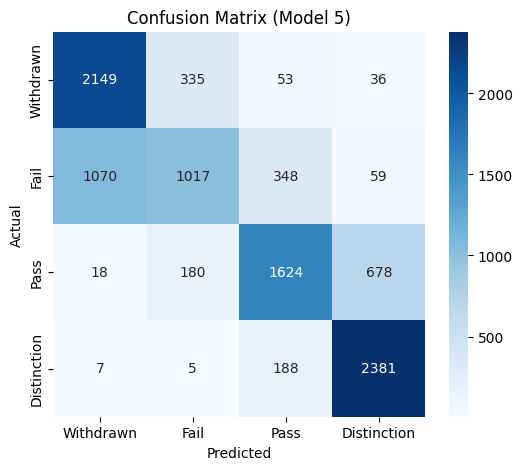

318/318 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step

[Info] Model 5 - 100% Course Progress:
 Precision: 0.7034, Recall: 0.7066, F1-score: 0.6923


In [20]:
models = {}
test_data_store = {}
# metrics_store = {}  # Store precision, recall, and F1-score for each model

for i in range(1, 6):
    model_i, (X_test_i, y_test_i) = train_early_model(X_resampled, y_resampled, i, epochs=50, is_binary=False)
    models[i] = model_i
    test_data_store[i] = (X_test_i, y_test_i)

        # Make Predictions
    y_pred_probs = model_i.predict(X_test_i)
    y_pred = np.argmax(y_pred_probs, axis=1)

    # Compute Precision, Recall, and F1-score
    precision = precision_score(y_test_i, y_pred, average='weighted')
    recall = recall_score(y_test_i, y_pred, average='weighted')
    f1 = f1_score(y_test_i, y_pred, average='weighted')

    # # Store Metrics
    # metrics_store[i] = {
    #     "precision": precision,
    #     "recall": recall,
    #     "f1_score": f1
    # }

    print(f"\n[Info] Model {i} - {i*20}% Course Progress:")
    print(f" Precision: {precision:.4f}, Recall: {recall:.4f}, F1-score: {f1:.4f}")

# # Convert metrics_store dictionary to lists for plotting
# precision_scores = [metrics_store[i]["precision"] for i in range(1, 6)]
# recall_scores = [metrics_store[i]["recall"] for i in range(1, 6)]
# f1_scores = [metrics_store[i]["f1_score"] for i in range(1, 6)]

# # Plot Precision, Recall, and F1-score
# plt.figure(figsize=(8, 5))
# plt.plot([20, 40, 60, 80, 100], f1_scores, marker='o', label="F1-score", linestyle='--')
# plt.plot([20, 40, 60, 80, 100], precision_scores, marker='s', label="Precision", linestyle='--')
# plt.plot([20, 40, 60, 80, 100], recall_scores, marker='^', label="Recall", linestyle='--')
# plt.xlabel("Course Progress (%)")
# plt.ylabel("Score")
# plt.title("Precision, Recall & F1-Score Growth Over Time")
# plt.legend()
# plt.grid()
# plt.show()


In [ ]:
# # Ablation Studies
# models_ablation = {}
# for i in range(1, 6):
#     print(f"\n--- Ablation Study for {i} segments ---")
#     # Model with both attention and ANN
#     model_i, (X_test_i, y_test_i) = train_early_model(X_resampled, y_resampled, i, epochs=20, use_attention=True, use_ann=True)
#     models_ablation[f"full_{i}"] = (model_i, (X_test_i, y_test_i))

#     # Model without attention
#     model_i_no_attn, _ = train_early_model(X_resampled, y_resampled, i, epochs=20, use_attention=False, use_ann=True)
#     models_ablation[f"no_attn_{i}"] = (model_i_no_attn, (X_test_i, y_test_i))

#     # Model without ANN
#     model_i_no_ann, _ = train_early_model(X_resampled, y_resampled, i, epochs=20, use_attention=True, use_ann=False)
#     models_ablation[f"no_ann_{i}"] = (model_i_no_ann, (X_test_i, y_test_i))

In [21]:
# Binary Classification Tasks
def binary_classification_task(X_data, y_data, task):
    """
    Perform binary classification based on the task:
    - WF-PD: Distinction/Pass vs. Fail/Withdrawn
    - F-PD: Fail vs. Distinction/Pass
    - W-PD: Withdrawn vs. Distinction/Pass
    """
    if task == "WF-PD":
        y_binary = np.where((y_data == 3) | (y_data == 2), 1, 0)  # Distinction/Pass = 1, Fail/Withdrawn = 0
    elif task == "F-PD":
        y_binary = np.where(y_data == 1, 1, 0)  # Fail = 1, Distinction/Pass = 0
    elif task == "W-PD":
        y_binary = np.where(y_data == 0, 1, 0)  # Withdrawn = 1, Distinction/Pass = 0
    else:
        raise ValueError("Invalid task. Choose from 'WF-PD', 'F-PD', 'W-PD'.")

    return X_data, y_binary


--- Binary Classification Task: WF-PD ---
[Info] Binary Classification Model
[Info] Training Model for 1 segments => 20% of course
Epoch 1/50
571/571 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - accuracy: 0.6234 - loss: 0.6309 - val_accuracy: 0.7466 - val_loss: 0.5268
Epoch 2/50
571/571 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - accuracy: 0.7517 - loss: 0.5136 - val_accuracy: 0.7633 - val_loss: 0.4991
Epoch 3/50
571/571 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - accuracy: 0.7610 - loss: 0.4988 - val_accuracy: 0.7778 - val_loss: 0.4746
Epoch 4/50
571/571 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.7668 - loss: 0.4909 - val_accuracy: 0.7549 - val_loss: 0.5002
Epoch 5/50
571/571 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - accuracy: 0.7689 - loss: 0.4857 - val_accuracy: 0.7685 - val_loss: 0.4722
Epoch 6/50
571/571 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.7709 - loss: 0.4804 - val_accuracy: 0.7800 - val_loss: 0.4575
Epoch 7/50
571/571 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - accuracy: 0.7759 - loss: 0.4696 - va

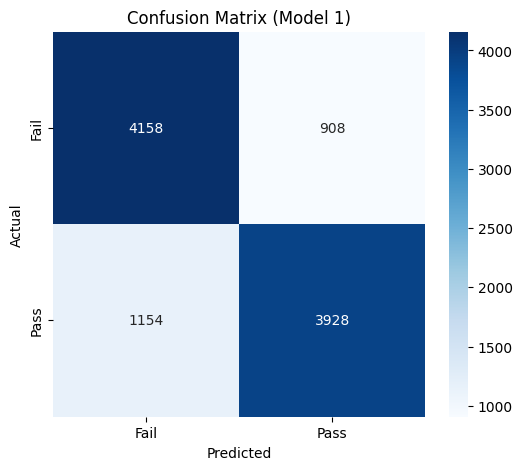

318/318 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
[Info] WF-PD - Model 1 - 20% Course Progress:
 Precision: 0.7975, Recall: 0.7968, F1-score: 0.7967

🔹 Classification Report:
              precision    recall  f1-score   support

     Class 0       0.78      0.82      0.80      5066
     Class 1       0.81      0.77      0.79      5082

    accuracy                           0.80     10148
   macro avg       0.80      0.80      0.80     10148
weighted avg       0.80      0.80      0.80     10148

[Info] Binary Classification Model
[Info] Training Model for 2 segments => 40% of course
Epoch 1/50
571/571 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - accuracy: 0.6664 - loss: 0.5877 - val_accuracy: 0.8025 - val_loss: 0.4225
Epoch 2/50
571/571 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - accuracy: 0.7989 - loss: 0.4325 - val_accuracy: 0.8022 - val_loss: 0.4209
Epoch 3/50
571/571 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - accuracy: 0.8111 - loss: 0.4130 - val_accuracy: 0.8155 - val_loss: 0.4004
Epoch 4/50
571/571 ━━━━━━━━━━━

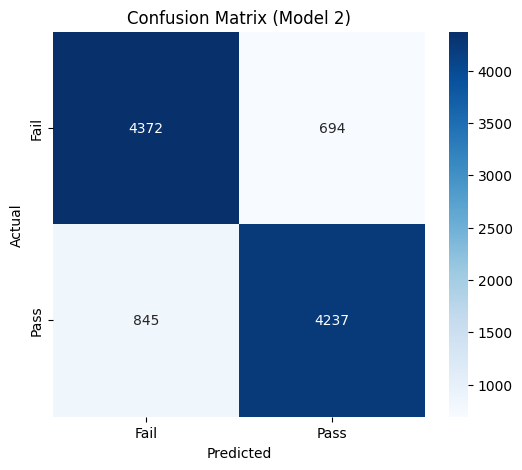

318/318 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
[Info] WF-PD - Model 2 - 40% Course Progress:
 Precision: 0.8487, Recall: 0.8483, F1-score: 0.8483

🔹 Classification Report:
              precision    recall  f1-score   support

     Class 0       0.84      0.86      0.85      5066
     Class 1       0.86      0.83      0.85      5082

    accuracy                           0.85     10148
   macro avg       0.85      0.85      0.85     10148
weighted avg       0.85      0.85      0.85     10148

[Info] Binary Classification Model
[Info] Training Model for 3 segments => 60% of course
Epoch 1/50
571/571 ━━━━━━━━━━━━━━━━━━━━ 12s 14ms/step - accuracy: 0.7432 - loss: 0.4909 - val_accuracy: 0.8687 - val_loss: 0.2847
Epoch 2/50
571/571 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - accuracy: 0.8590 - loss: 0.3128 - val_accuracy: 0.8682 - val_loss: 0.2958
Epoch 3/50
571/571 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - accuracy: 0.8676 - loss: 0.3024 - val_accuracy: 0.8722 - val_loss: 0.2851
Epoch 4/50
571/571 ━━━━━━━━━━━

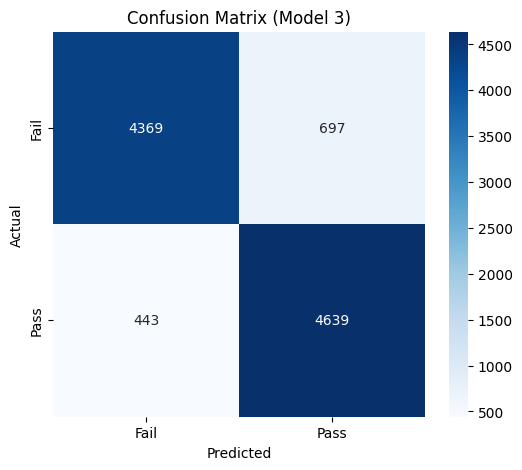

318/318 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
[Info] WF-PD - Model 3 - 60% Course Progress:
 Precision: 0.8886, Recall: 0.8877, F1-score: 0.8876

🔹 Classification Report:
              precision    recall  f1-score   support

     Class 0       0.91      0.86      0.88      5066
     Class 1       0.87      0.91      0.89      5082

    accuracy                           0.89     10148
   macro avg       0.89      0.89      0.89     10148
weighted avg       0.89      0.89      0.89     10148

[Info] Binary Classification Model
[Info] Training Model for 4 segments => 80% of course
Epoch 1/50
571/571 ━━━━━━━━━━━━━━━━━━━━ 12s 14ms/step - accuracy: 0.7907 - loss: 0.4161 - val_accuracy: 0.8931 - val_loss: 0.2567
Epoch 2/50
571/571 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - accuracy: 0.8905 - loss: 0.2515 - val_accuracy: 0.9002 - val_loss: 0.2450
Epoch 3/50
571/571 ━━━━━━━━━━━━━━━━━━━━ 8s 13ms/step - accuracy: 0.8997 - loss: 0.2404 - val_accuracy: 0.8998 - val_loss: 0.2390
Epoch 4/50
571/571 ━━━━━━━━━━━

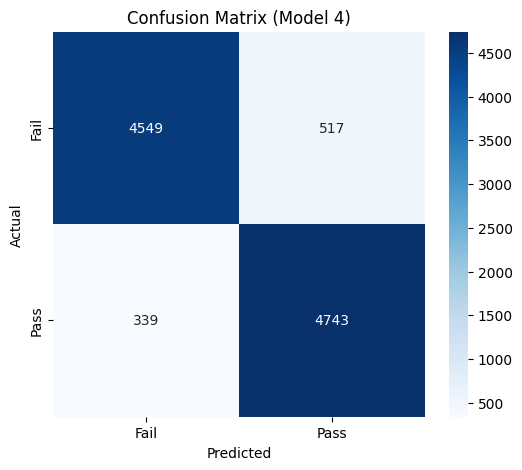

318/318 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
[Info] WF-PD - Model 4 - 80% Course Progress:
 Precision: 0.9162, Recall: 0.9156, F1-score: 0.9156

🔹 Classification Report:
              precision    recall  f1-score   support

     Class 0       0.93      0.90      0.91      5066
     Class 1       0.90      0.93      0.92      5082

    accuracy                           0.92     10148
   macro avg       0.92      0.92      0.92     10148
weighted avg       0.92      0.92      0.92     10148

[Info] Binary Classification Model
[Info] Training Model for 5 segments => 100% of course
Epoch 1/50
571/571 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - accuracy: 0.8246 - loss: 0.3689 - val_accuracy: 0.8956 - val_loss: 0.2397
Epoch 2/50
571/571 ━━━━━━━━━━━━━━━━━━━━ 8s 13ms/step - accuracy: 0.8947 - loss: 0.2473 - val_accuracy: 0.9054 - val_loss: 0.2204
Epoch 3/50
571/571 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - accuracy: 0.8982 - loss: 0.2349 - val_accuracy: 0.9113 - val_loss: 0.2094
Epoch 4/50
571/571 ━━━━━━━━━━

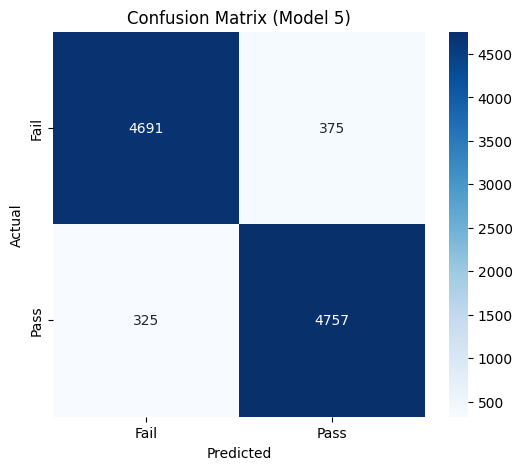

318/318 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
[Info] WF-PD - Model 5 - 100% Course Progress:
 Precision: 0.9311, Recall: 0.9310, F1-score: 0.9310

🔹 Classification Report:
              precision    recall  f1-score   support

     Class 0       0.94      0.93      0.93      5066
     Class 1       0.93      0.94      0.93      5082

    accuracy                           0.93     10148
   macro avg       0.93      0.93      0.93     10148
weighted avg       0.93      0.93      0.93     10148


--- Binary Classification Task: F-PD ---
[Info] Binary Classification Model
[Info] Training Model for 1 segments => 20% of course
Epoch 1/50
571/571 ━━━━━━━━━━━━━━━━━━━━ 13s 11ms/step - accuracy: 0.7510 - loss: 0.5517 - val_accuracy: 0.7574 - val_loss: 0.4971
Epoch 2/50
571/571 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - accuracy: 0.7545 - loss: 0.4995 - val_accuracy: 0.7574 - val_loss: 0.4967
Epoch 3/50
571/571 ━━━━━━━━━━━━━━━━━━━━ 11s 13ms/step - accuracy: 0.7546 - loss: 0.5037 - val_accuracy: 0.7574 - va

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


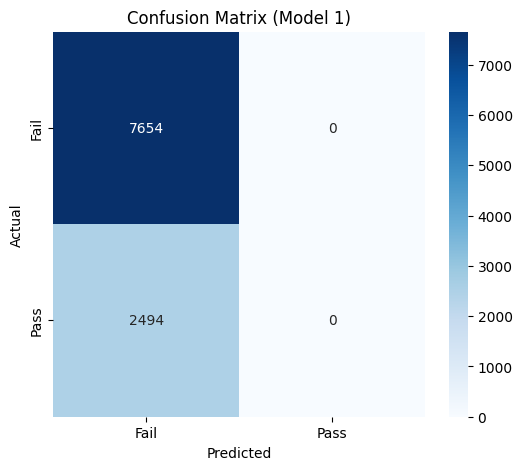

318/318 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
[Info] F-PD - Model 1 - 20% Course Progress:
 Precision: 0.5689, Recall: 0.7542, F1-score: 0.6486

🔹 Classification Report:
              precision    recall  f1-score   support

     Class 0       0.75      1.00      0.86      7654
     Class 1       0.00      0.00      0.00      2494

    accuracy                           0.75     10148
   macro avg       0.38      0.50      0.43     10148
weighted avg       0.57      0.75      0.65     10148

[Info] Binary Classification Model
[Info] Training Model for 2 segments => 40% of course
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m

571/571 ━━━━━━━━━━━━━━━━━━━━ 14s 13ms/step - accuracy: 0.7528 - loss: 0.5473 - val_accuracy: 0.7574 - val_loss: 0.4890
Epoch 2/50
571/571 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - accuracy: 0.7544 - loss: 0.4904 - val_accuracy: 0.7574 - val_loss: 0.5006
Epoch 3/50
571/571 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - accuracy: 0.7521 - loss: 0.4889 - val_accuracy: 0.7574 - val_loss: 0.4886
Epoch 4/50
571/571 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - accuracy: 0.7564 - loss: 0.4785 - val_accuracy: 0.7574 - val_loss: 0.4919
Epoch 5/50
571/571 ━━━━━━━━━━━━━━━━━━━━ 8s 13ms/step - accuracy: 0.7516 - loss: 0.4797 - val_accuracy: 0.7574 - val_loss: 0.5017
Epoch 6/50
571/571 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - accuracy: 0.7540 - loss: 0.4710 - val_accuracy: 0.7574 - val_loss: 0.4869
Epoch 7/50
571/571 ━━━━━━━━━━━━━━━━━━━━ 8s 13ms/step - accuracy: 0.7573 - loss: 0.4674 - val_accuracy: 0.7574 - val_loss: 0.4752
Epoch 8/50
571/571 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - accuracy: 0.7572 - loss: 0.4687 - val_accuracy: 0.75

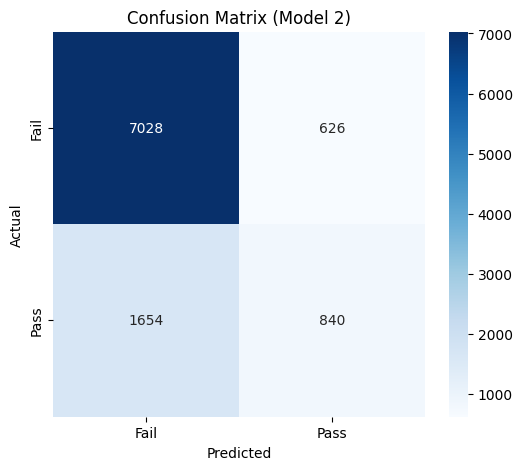

318/318 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
[Info] F-PD - Model 2 - 40% Course Progress:
 Precision: 0.7514, Recall: 0.7753, F1-score: 0.7532

🔹 Classification Report:
              precision    recall  f1-score   support

     Class 0       0.81      0.92      0.86      7654
     Class 1       0.57      0.34      0.42      2494

    accuracy                           0.78     10148
   macro avg       0.69      0.63      0.64     10148
weighted avg       0.75      0.78      0.75     10148

[Info] Binary Classification Model
[Info] Training Model for 3 segments => 60% of course
Epoch 1/50
571/571 ━━━━━━━━━━━━━━━━━━━━ 12s 14ms/step - accuracy: 0.7486 - loss: 0.5427 - val_accuracy: 0.7574 - val_loss: 0.4850
Epoch 2/50
571/571 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - accuracy: 0.7554 - loss: 0.4819 - val_accuracy: 0.7490 - val_loss: 0.4676
Epoch 3/50
571/571 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - accuracy: 0.7557 - loss: 0.4621 - val_accuracy: 0.7552 - val_loss: 0.4997
Epoch 4/50
571/571 ━━━━━━━━━━━━

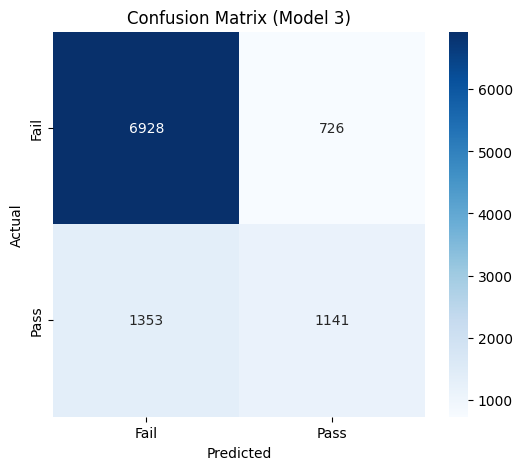

318/318 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
[Info] F-PD - Model 3 - 60% Course Progress:
 Precision: 0.7812, Recall: 0.7951, F1-score: 0.7844

🔹 Classification Report:
              precision    recall  f1-score   support

     Class 0       0.84      0.91      0.87      7654
     Class 1       0.61      0.46      0.52      2494

    accuracy                           0.80     10148
   macro avg       0.72      0.68      0.70     10148
weighted avg       0.78      0.80      0.78     10148

[Info] Binary Classification Model
[Info] Training Model for 4 segments => 80% of course
Epoch 1/50
571/571 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - accuracy: 0.7522 - loss: 0.5285 - val_accuracy: 0.7574 - val_loss: 0.4688
Epoch 2/50
571/571 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - accuracy: 0.7497 - loss: 0.4644 - val_accuracy: 0.7697 - val_loss: 0.4442
Epoch 3/50
571/571 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - accuracy: 0.7617 - loss: 0.4410 - val_accuracy: 0.7687 - val_loss: 0.4402
Epoch 4/50
571/571 ━━━━━━━━━━

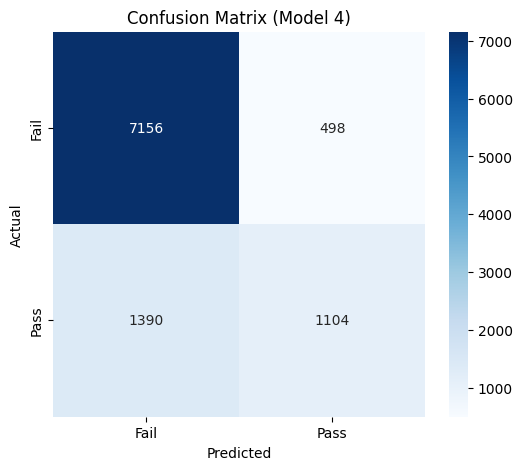

318/318 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
[Info] F-PD - Model 4 - 80% Course Progress:
 Precision: 0.8009, Recall: 0.8140, F1-score: 0.7988

🔹 Classification Report:
              precision    recall  f1-score   support

     Class 0       0.84      0.93      0.88      7654
     Class 1       0.69      0.44      0.54      2494

    accuracy                           0.81     10148
   macro avg       0.76      0.69      0.71     10148
weighted avg       0.80      0.81      0.80     10148

[Info] Binary Classification Model
[Info] Training Model for 5 segments => 100% of course
Epoch 1/50
571/571 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - accuracy: 0.7531 - loss: 0.5172 - val_accuracy: 0.7603 - val_loss: 0.5102
Epoch 2/50
571/571 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - accuracy: 0.7548 - loss: 0.4650 - val_accuracy: 0.7599 - val_loss: 0.4533
Epoch 3/50
571/571 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - accuracy: 0.7596 - loss: 0.4498 - val_accuracy: 0.7586 - val_loss: 0.4455
Epoch 4/50
571/571 ━━━━━━━━━━━

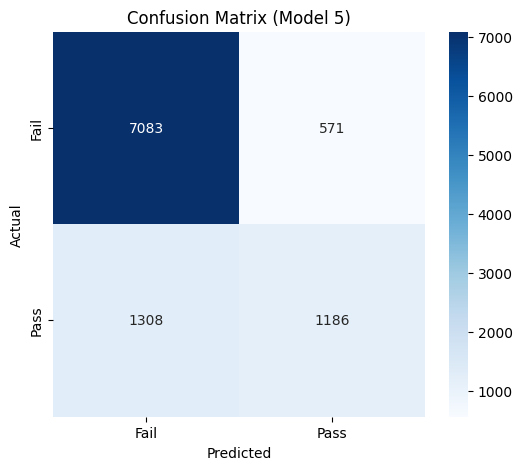

318/318 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
[Info] F-PD - Model 5 - 100% Course Progress:
 Precision: 0.8026, Recall: 0.8148, F1-score: 0.8030

🔹 Classification Report:
              precision    recall  f1-score   support

     Class 0       0.84      0.93      0.88      7654
     Class 1       0.68      0.48      0.56      2494

    accuracy                           0.81     10148
   macro avg       0.76      0.70      0.72     10148
weighted avg       0.80      0.81      0.80     10148


--- Binary Classification Task: W-PD ---
[Info] Binary Classification Model
[Info] Training Model for 1 segments => 20% of course
Epoch 1/50
571/571 ━━━━━━━━━━━━━━━━━━━━ 14s 14ms/step - accuracy: 0.7430 - loss: 0.5614 - val_accuracy: 0.7470 - val_loss: 0.4947
Epoch 2/50
571/571 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - accuracy: 0.7471 - loss: 0.5015 - val_accuracy: 0.7470 - val_loss: 0.4892
Epoch 3/50
571/571 ━━━━━━━━━━━━━━━━━━━━ 8s 13ms/step - accuracy: 0.7472 - loss: 0.4928 - val_accuracy: 0.7470 - val_l

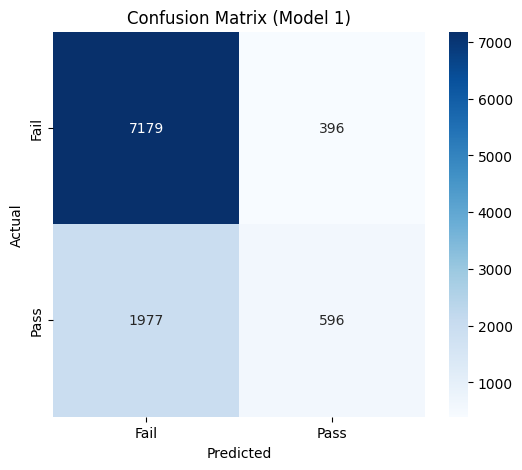

318/318 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
[Info] W-PD - Model 1 - 20% Course Progress:
 Precision: 0.7376, Recall: 0.7662, F1-score: 0.7254

🔹 Classification Report:
              precision    recall  f1-score   support

     Class 0       0.78      0.95      0.86      7575
     Class 1       0.60      0.23      0.33      2573

    accuracy                           0.77     10148
   macro avg       0.69      0.59      0.60     10148
weighted avg       0.74      0.77      0.73     10148

[Info] Binary Classification Model
[Info] Training Model for 2 segments => 40% of course
Epoch 1/50
571/571 ━━━━━━━━━━━━━━━━━━━━ 12s 14ms/step - accuracy: 0.7639 - loss: 0.5227 - val_accuracy: 0.7877 - val_loss: 0.4597
Epoch 2/50
571/571 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - accuracy: 0.7890 - loss: 0.4462 - val_accuracy: 0.7909 - val_loss: 0.4373
Epoch 3/50
571/571 ━━━━━━━━━━━━━━━━━━━━ 8s 13ms/step - accuracy: 0.7887 - loss: 0.4412 - val_accuracy: 0.7882 - val_loss: 0.4365
Epoch 4/50
571/571 ━━━━━━━━━━━━

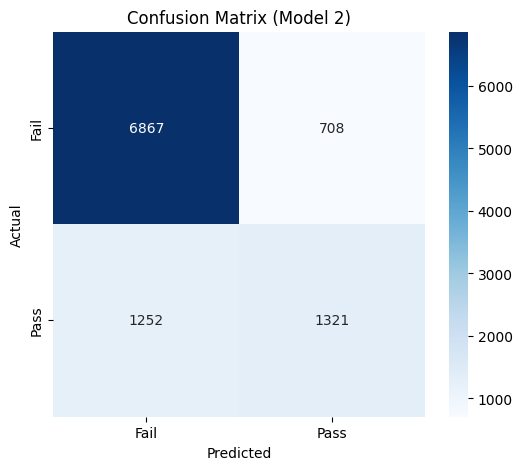

318/318 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
[Info] W-PD - Model 2 - 40% Course Progress:
 Precision: 0.7964, Recall: 0.8069, F1-score: 0.7988

🔹 Classification Report:
              precision    recall  f1-score   support

     Class 0       0.85      0.91      0.88      7575
     Class 1       0.65      0.51      0.57      2573

    accuracy                           0.81     10148
   macro avg       0.75      0.71      0.72     10148
weighted avg       0.80      0.81      0.80     10148

[Info] Binary Classification Model
[Info] Training Model for 3 segments => 60% of course
Epoch 1/50
571/571 ━━━━━━━━━━━━━━━━━━━━ 13s 15ms/step - accuracy: 0.7778 - loss: 0.4823 - val_accuracy: 0.8232 - val_loss: 0.3774
Epoch 2/50
571/571 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - accuracy: 0.8226 - loss: 0.3932 - val_accuracy: 0.8268 - val_loss: 0.3773
Epoch 3/50
571/571 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - accuracy: 0.8237 - loss: 0.3850 - val_accuracy: 0.8268 - val_loss: 0.3812
Epoch 4/50
571/571 ━━━━━━━━━━━━

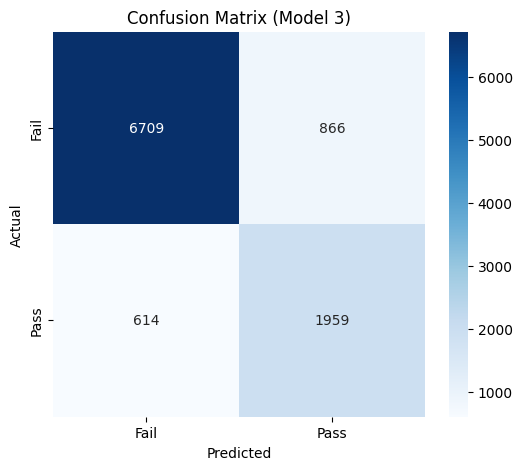

318/318 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
[Info] W-PD - Model 3 - 60% Course Progress:
 Precision: 0.8597, Recall: 0.8542, F1-score: 0.8563

🔹 Classification Report:
              precision    recall  f1-score   support

     Class 0       0.92      0.89      0.90      7575
     Class 1       0.69      0.76      0.73      2573

    accuracy                           0.85     10148
   macro avg       0.80      0.82      0.81     10148
weighted avg       0.86      0.85      0.86     10148

[Info] Binary Classification Model
[Info] Training Model for 4 segments => 80% of course
Epoch 1/50
571/571 ━━━━━━━━━━━━━━━━━━━━ 12s 14ms/step - accuracy: 0.8000 - loss: 0.4356 - val_accuracy: 0.8266 - val_loss: 0.3608
Epoch 2/50
571/571 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - accuracy: 0.8203 - loss: 0.3628 - val_accuracy: 0.8227 - val_loss: 0.3772
Epoch 3/50
571/571 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - accuracy: 0.8279 - loss: 0.3539 - val_accuracy: 0.8345 - val_loss: 0.3467
Epoch 4/50
571/571 ━━━━━━━━━━━

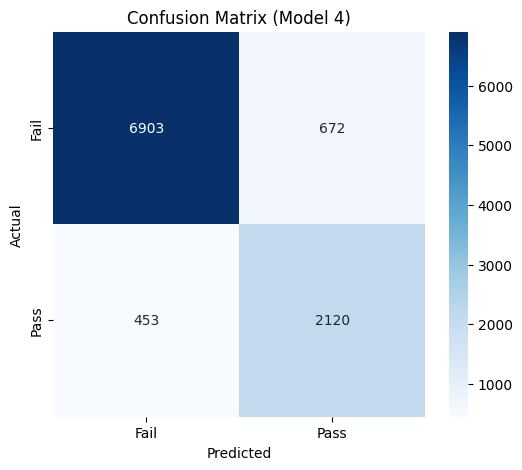

318/318 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
[Info] W-PD - Model 4 - 80% Course Progress:
 Precision: 0.8930, Recall: 0.8891, F1-score: 0.8906

🔹 Classification Report:
              precision    recall  f1-score   support

     Class 0       0.94      0.91      0.92      7575
     Class 1       0.76      0.82      0.79      2573

    accuracy                           0.89     10148
   macro avg       0.85      0.87      0.86     10148
weighted avg       0.89      0.89      0.89     10148

[Info] Binary Classification Model
[Info] Training Model for 5 segments => 100% of course
Epoch 1/50
571/571 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - accuracy: 0.7960 - loss: 0.4122 - val_accuracy: 0.8308 - val_loss: 0.3445
Epoch 2/50
571/571 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - accuracy: 0.8247 - loss: 0.3475 - val_accuracy: 0.8291 - val_loss: 0.3365
Epoch 3/50
571/571 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step - accuracy: 0.8250 - loss: 0.3426 - val_accuracy: 0.8313 - val_loss: 0.3313
Epoch 4/50
571/571 ━━━━━━━━━━━

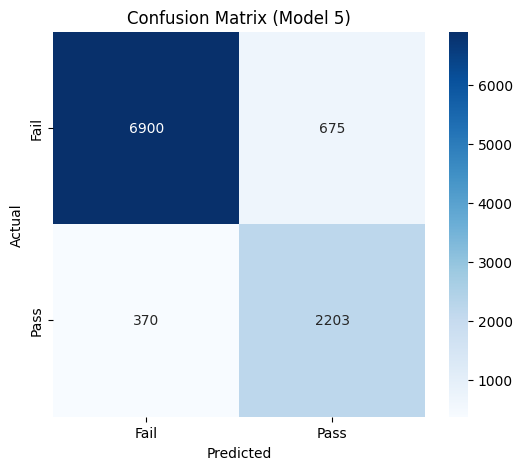

318/318 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
[Info] W-PD - Model 5 - 100% Course Progress:
 Precision: 0.9025, Recall: 0.8970, F1-score: 0.8988

🔹 Classification Report:
              precision    recall  f1-score   support

     Class 0       0.95      0.91      0.93      7575
     Class 1       0.77      0.86      0.81      2573

    accuracy                           0.90     10148
   macro avg       0.86      0.88      0.87     10148
weighted avg       0.90      0.90      0.90     10148



In [23]:
# Perform binary classification tasks
binary_tasks = ["WF-PD", "F-PD", "W-PD"]
# binary_metrics_store = {}  # Store precision, recall, and F1-score for each binary model

for task in binary_tasks:
    print(f"\n--- Binary Classification Task: {task} ---")
    X_binary, y_binary = binary_classification_task(X_resampled, y_resampled, task)
    for i in range(1, 6):
        model_i, (X_test_i, y_test_i) = train_early_model(X_binary, y_binary, i, epochs=50, is_binary=True)
        models[f"{task}_{i}"] = model_i
        test_data_store[f"{task}_{i}"] = (X_test_i, y_test_i)

        # Make Predictions
        y_pred_probs = model_i.predict(X_test_i)
        y_pred = (y_pred_probs > 0.5).astype(int)  # Convert probabilities to binary predictions

        # Compute Precision, Recall, and F1-score
        precision = precision_score(y_test_i, y_pred, average='weighted')
        recall = recall_score(y_test_i, y_pred, average='weighted')
        f1 = f1_score(y_test_i, y_pred, average='weighted')

        # Store Metrics
        # if task not in binary_metrics_store:
        #     binary_metrics_store[task] = {
        #         "precision": [], "recall": [], "f1_score": []
        #     }

        # binary_metrics_store[task]["precision"].append(precision)
        # binary_metrics_store[task]["recall"].append(recall)
        # binary_metrics_store[task]["f1_score"].append(f1)

        print(f"[Info] {task} - Model {i} - {i*20}% Course Progress:")
        print(f" Precision: {precision:.4f}, Recall: {recall:.4f}, F1-score: {f1:.4f}")

        # Print Classification Report
        print("\n🔹 Classification Report:")
        print(classification_report(y_test_i, y_pred, target_names=['Class 0', 'Class 1']))

# # Plot Precision, Recall, and F1-score for Binary Tasks
# plt.figure(figsize=(10, 6))
# for task in binary_tasks:
#     plt.plot([20, 40, 60, 80, 100], binary_metrics_store[task]["f1_score"], marker='o', linestyle='--', label=f"{task} - F1-score")
#     plt.xlabel("Course Progress (%)")
#     plt.ylabel("F1-Score")
#     plt.title("F1-Score Growth for Binary Classification Tasks")
#     plt.legend()
#     plt.grid()
#     plt.show()


In [24]:
import os
from google.colab import files

# 1. Create a directory to store all saved models
save_dir = "/content/drive/MyDrive/FYP/Dataset/trained/saved_models"
os.makedirs(save_dir, exist_ok=True)

# 2. Loop over your models dictionary and save each model
# (Assuming your models are stored in the 'models' dictionary)
for key, model in models.items():
    # Create a filename based on the model key (e.g., 1, 2, "WF-PD_5", etc.)
    filename = f"model_{key}.h5"
    filepath = os.path.join(save_dir, filename)
    model.save(filepath)
    print(f"Saved model {key} to {filepath}")

# 3. Zip the folder containing all saved models
zip_filepath = "/content/saved_models.zip"
!zip -r $zip_filepath "$save_dir"

# 4. Download the zip file to your local machine
files.download(zip_filepath)

Saved model 1 to /content/drive/MyDrive/FYP/Dataset/trained/saved_models/model_1.h5
Saved model 2 to /content/drive/MyDrive/FYP/Dataset/trained/saved_models/model_2.h5
Saved model 3 to /content/drive/MyDrive/FYP/Dataset/trained/saved_models/model_3.h5


Saved model 4 to /content/drive/MyDrive/FYP/Dataset/trained/saved_models/model_4.h5
Saved model 5 to /content/drive/MyDrive/FYP/Dataset/trained/saved_models/model_5.h5
Saved model WF-PD_1 to /content/drive/MyDrive/FYP/Dataset/trained/saved_models/model_WF-PD_1.h5


Saved model WF-PD_2 to /content/drive/MyDrive/FYP/Dataset/trained/saved_models/model_WF-PD_2.h5
Saved model WF-PD_3 to /content/drive/MyDrive/FYP/Dataset/trained/saved_models/model_WF-PD_3.h5


Saved model WF-PD_4 to /content/drive/MyDrive/FYP/Dataset/trained/saved_models/model_WF-PD_4.h5
Saved model WF-PD_5 to /content/drive/MyDrive/FYP/Dataset/trained/saved_models/model_WF-PD_5.h5


Saved model F-PD_1 to /content/drive/MyDrive/FYP/Dataset/trained/saved_models/model_F-PD_1.h5
Saved model F-PD_2 to /content/drive/MyDrive/FYP/Dataset/trained/saved_models/model_F-PD_2.h5


Saved model F-PD_3 to /content/drive/MyDrive/FYP/Dataset/trained/saved_models/model_F-PD_3.h5
Saved model F-PD_4 to /content/drive/MyDrive/FYP/Dataset/trained/saved_models/model_F-PD_4.h5


Saved model F-PD_5 to /content/drive/MyDrive/FYP/Dataset/trained/saved_models/model_F-PD_5.h5
Saved model W-PD_1 to /content/drive/MyDrive/FYP/Dataset/trained/saved_models/model_W-PD_1.h5
Saved model W-PD_2 to /content/drive/MyDrive/FYP/Dataset/trained/saved_models/model_W-PD_2.h5


Saved model W-PD_3 to /content/drive/MyDrive/FYP/Dataset/trained/saved_models/model_W-PD_3.h5
Saved model W-PD_4 to /content/drive/MyDrive/FYP/Dataset/trained/saved_models/model_W-PD_4.h5
Saved model W-PD_5 to /content/drive/MyDrive/FYP/Dataset/trained/saved_models/model_W-PD_5.h5
  adding: content/drive/MyDrive/FYP/Dataset/trained/saved_models/ (stored 0%)
  adding: content/drive/MyDrive/FYP/Dataset/trained/saved_models/model_1.h5 (deflated 46%)
  adding: content/drive/MyDrive/FYP/Dataset/trained/saved_models/model_2.h5 (deflated 10%)
  adding: content/drive/MyDrive/FYP/Dataset/trained/saved_models/model_3.h5 (deflated 11%)
  adding: content/drive/MyDrive/FYP/Dataset/trained/saved_models/model_4.h5 (deflated 11%)
  adding: content/drive/MyDrive/FYP/Dataset/trained/saved_models/model_5.h5 (deflated 11%)
  adding: content/drive/MyDrive/FYP/Dataset/trained/saved_models/model_WF-PD_1.h5 (deflated 46%)
  adding: content/drive/MyDrive/FYP/Dataset/trained/saved_models/model_WF-PD_2.h5 (defla

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Single-Student Demo with full 5-segment model

In [33]:
# model_5 = models['WF-PD_5']
# X_test_5, y_test_5 = test_data_store[5]

# import random
# sample_idx = random.randint(0, len(X_test_5)-1)
# sample_seq = X_test_5[sample_idx]  # shape (5,F)
# sample_seq = np.expand_dims(sample_seq, axis=0)

# pred_probs = model_5.predict(sample_seq)
# pred_class = np.argmax(pred_probs, axis=1)[0]
# class_map = {0:'Withdrawn',1:'Fail',2:'Pass',3:'Distinction'}

# actual = class_map[y_test_5[sample_idx]]
# predicted = class_map[pred_class]

# print(f"\n--- Single Student Example (Full 5 segments) ---")
# print(f"Actual:    {actual}")
# print(f"Predicted: {predicted}")

# Single-Student Demo with full 5-segment model
model_5 = models["WF-PD_5"][0]
X_test_5, y_test_5 = models["WF-PD_5"][1]

import random
sample_idx = random.randint(0, len(X_test_5)-1)
sample_seq = X_test_5[sample_idx]  # shape (5,F)
sample_seq = np.expand_dims(sample_seq, axis=0)

pred_probs = model_5.predict(sample_seq)
pred_class = np.argmax(pred_probs, axis=1)[0]
class_map = {0:'Withdrawn',1:'Fail',2:'Pass',3:'Distinction'}

actual = class_map[y_test_5[sample_idx]]
predicted = class_map[pred_class]

print(f"\n--- Single Student Example (Full 5 segments) ---")
print(f"Actual:    {actual}")
print(f"Predicted: {predicted}")

TypeError: 'Functional' object is not subscriptable


[Info] Testing model 1 on 10148 samples.
318/318 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
[Info] Model 1 - Test Accuracy: 0.5034
[Info] Classification Report:
              precision    recall  f1-score   support

   Withdrawn       0.51      0.51      0.51      2573
        Fail       0.39      0.40      0.39      2494
        Pass       0.45      0.33      0.38      2500
 Distinction       0.63      0.75      0.69      2581

    accuracy                           0.50     10148
   macro avg       0.49      0.50      0.49     10148
weighted avg       0.50      0.50      0.50     10148



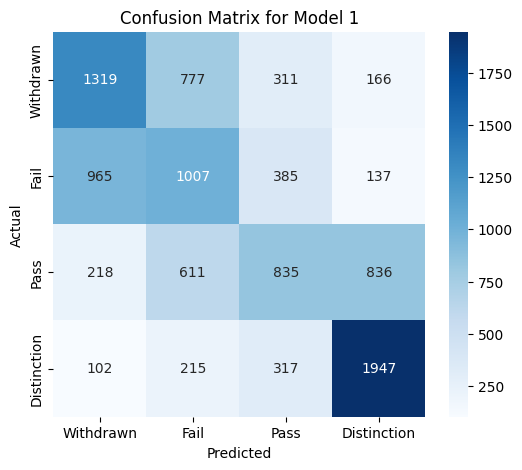


[Info] Testing model 2 on 10148 samples.
318/318 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
[Info] Model 2 - Test Accuracy: 0.5672
[Info] Classification Report:
              precision    recall  f1-score   support

   Withdrawn       0.58      0.59      0.58      2573
        Fail       0.47      0.41      0.44      2494
        Pass       0.50      0.43      0.47      2500
 Distinction       0.67      0.83      0.74      2581

    accuracy                           0.57     10148
   macro avg       0.55      0.56      0.56     10148
weighted avg       0.56      0.57      0.56     10148



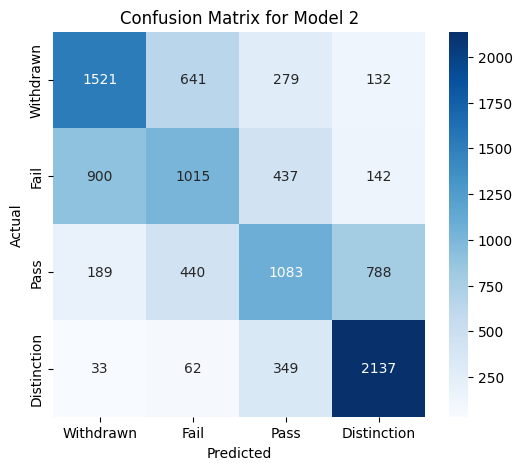


[Info] Testing model 3 on 10148 samples.
318/318 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
[Info] Model 3 - Test Accuracy: 0.6426
[Info] Classification Report:
              precision    recall  f1-score   support

   Withdrawn       0.63      0.76      0.69      2573
        Fail       0.54      0.38      0.45      2494
        Pass       0.60      0.56      0.58      2500
 Distinction       0.74      0.86      0.80      2581

    accuracy                           0.64     10148
   macro avg       0.63      0.64      0.63     10148
weighted avg       0.63      0.64      0.63     10148



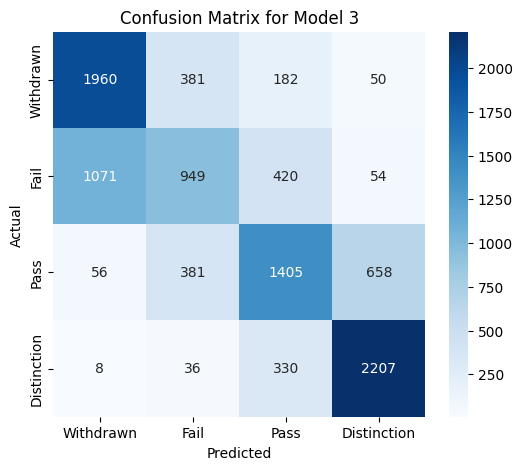


[Info] Testing model 4 on 10148 samples.
318/318 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
[Info] Model 4 - Test Accuracy: 0.6744
[Info] Classification Report:
              precision    recall  f1-score   support

   Withdrawn       0.66      0.78      0.72      2573
        Fail       0.59      0.43      0.50      2494
        Pass       0.69      0.54      0.61      2500
 Distinction       0.72      0.94      0.81      2581

    accuracy                           0.67     10148
   macro avg       0.67      0.67      0.66     10148
weighted avg       0.67      0.67      0.66     10148



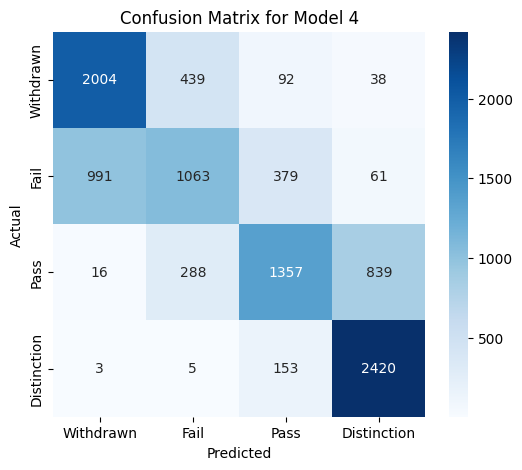


[Info] Testing model 5 on 10148 samples.
318/318 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
[Info] Model 5 - Test Accuracy: 0.7066
[Info] Classification Report:
              precision    recall  f1-score   support

   Withdrawn       0.66      0.84      0.74      2573
        Fail       0.66      0.41      0.50      2494
        Pass       0.73      0.65      0.69      2500
 Distinction       0.75      0.92      0.83      2581

    accuracy                           0.71     10148
   macro avg       0.70      0.70      0.69     10148
weighted avg       0.70      0.71      0.69     10148



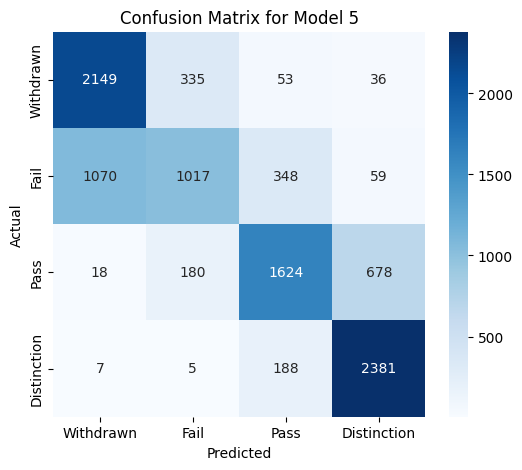


[Info] Testing model WF-PD_1 on 10148 samples.
318/318 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
[Info] Model WF-PD_1 - Test Accuracy: 0.7968
[Info] Classification Report:
              precision    recall  f1-score   support

     Class 0       0.78      0.82      0.80      5066
     Class 1       0.81      0.77      0.79      5082

    accuracy                           0.80     10148
   macro avg       0.80      0.80      0.80     10148
weighted avg       0.80      0.80      0.80     10148



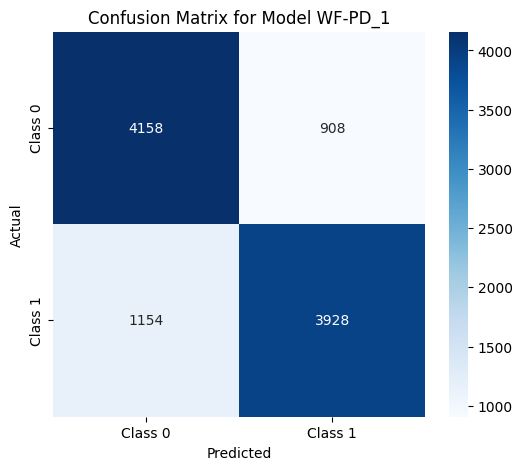


[Info] Testing model WF-PD_2 on 10148 samples.
318/318 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
[Info] Model WF-PD_2 - Test Accuracy: 0.8483
[Info] Classification Report:
              precision    recall  f1-score   support

     Class 0       0.84      0.86      0.85      5066
     Class 1       0.86      0.83      0.85      5082

    accuracy                           0.85     10148
   macro avg       0.85      0.85      0.85     10148
weighted avg       0.85      0.85      0.85     10148



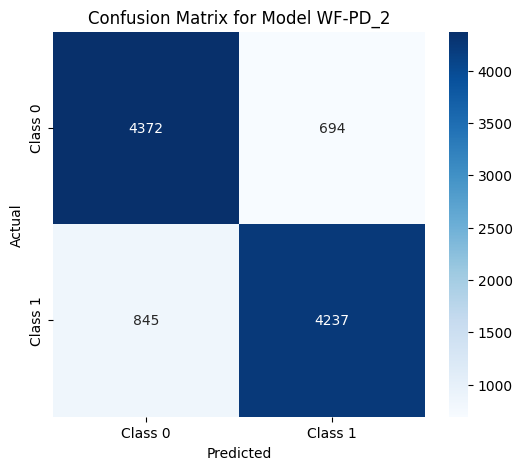


[Info] Testing model WF-PD_3 on 10148 samples.
318/318 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
[Info] Model WF-PD_3 - Test Accuracy: 0.8877
[Info] Classification Report:
              precision    recall  f1-score   support

     Class 0       0.91      0.86      0.88      5066
     Class 1       0.87      0.91      0.89      5082

    accuracy                           0.89     10148
   macro avg       0.89      0.89      0.89     10148
weighted avg       0.89      0.89      0.89     10148



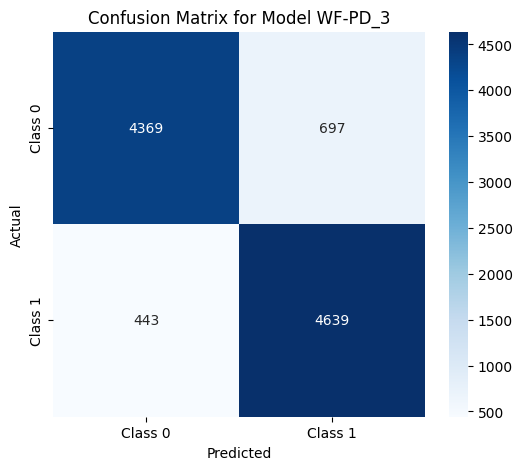


[Info] Testing model WF-PD_4 on 10148 samples.
318/318 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
[Info] Model WF-PD_4 - Test Accuracy: 0.9156
[Info] Classification Report:
              precision    recall  f1-score   support

     Class 0       0.93      0.90      0.91      5066
     Class 1       0.90      0.93      0.92      5082

    accuracy                           0.92     10148
   macro avg       0.92      0.92      0.92     10148
weighted avg       0.92      0.92      0.92     10148



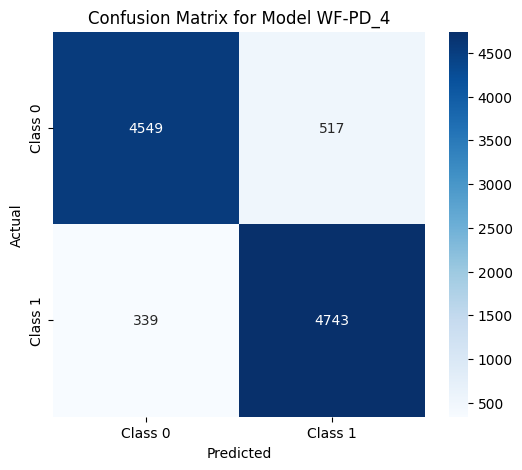


[Info] Testing model WF-PD_5 on 10148 samples.
318/318 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
[Info] Model WF-PD_5 - Test Accuracy: 0.9310
[Info] Classification Report:
              precision    recall  f1-score   support

     Class 0       0.94      0.93      0.93      5066
     Class 1       0.93      0.94      0.93      5082

    accuracy                           0.93     10148
   macro avg       0.93      0.93      0.93     10148
weighted avg       0.93      0.93      0.93     10148



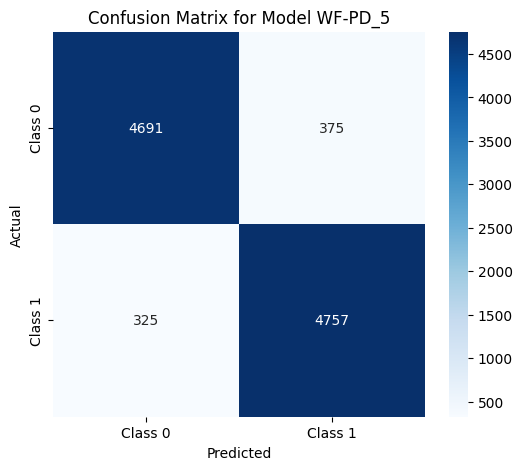


[Info] Testing model F-PD_1 on 10148 samples.
318/318 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
[Info] Model F-PD_1 - Test Accuracy: 0.7542
[Info] Classification Report:
              precision    recall  f1-score   support

     Class 0       0.75      1.00      0.86      7654
     Class 1       0.00      0.00      0.00      2494

    accuracy                           0.75     10148
   macro avg       0.38      0.50      0.43     10148
weighted avg       0.57      0.75      0.65     10148



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


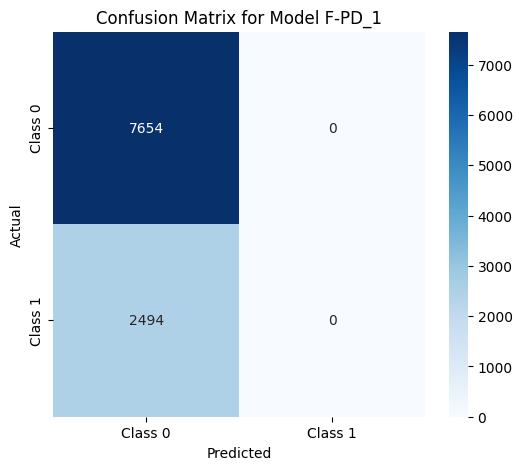


[Info] Testing model F-PD_2 on 10148 samples.
318/318 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
[Info] Model F-PD_2 - Test Accuracy: 0.7753
[Info] Classification Report:
              precision    recall  f1-score   support

     Class 0       0.81      0.92      0.86      7654
     Class 1       0.57      0.34      0.42      2494

    accuracy                           0.78     10148
   macro avg       0.69      0.63      0.64     10148
weighted avg       0.75      0.78      0.75     10148



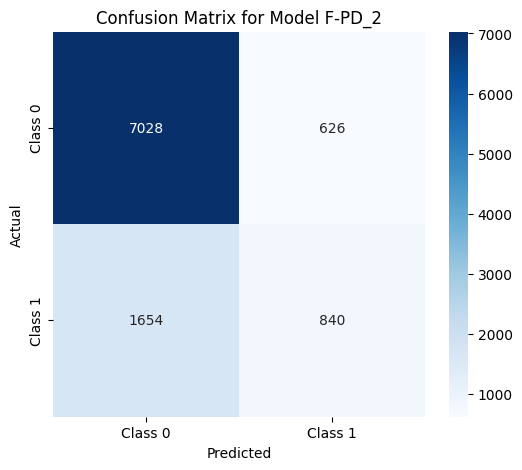


[Info] Testing model F-PD_3 on 10148 samples.
318/318 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
[Info] Model F-PD_3 - Test Accuracy: 0.7951
[Info] Classification Report:
              precision    recall  f1-score   support

     Class 0       0.84      0.91      0.87      7654
     Class 1       0.61      0.46      0.52      2494

    accuracy                           0.80     10148
   macro avg       0.72      0.68      0.70     10148
weighted avg       0.78      0.80      0.78     10148



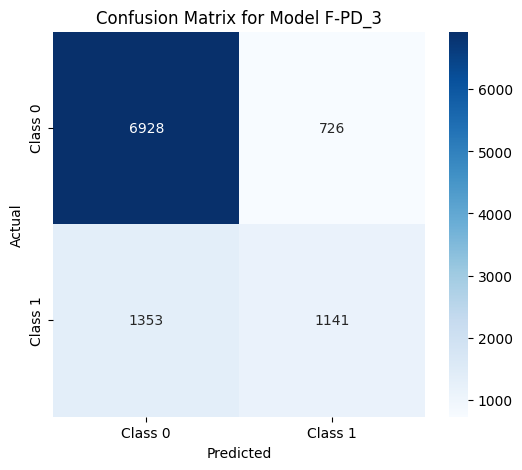


[Info] Testing model F-PD_4 on 10148 samples.
318/318 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
[Info] Model F-PD_4 - Test Accuracy: 0.8140
[Info] Classification Report:
              precision    recall  f1-score   support

     Class 0       0.84      0.93      0.88      7654
     Class 1       0.69      0.44      0.54      2494

    accuracy                           0.81     10148
   macro avg       0.76      0.69      0.71     10148
weighted avg       0.80      0.81      0.80     10148



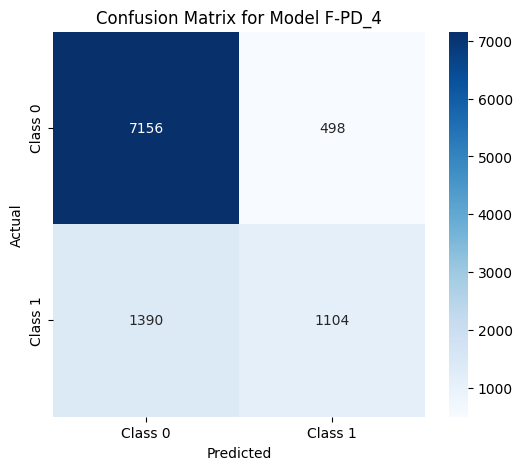


[Info] Testing model F-PD_5 on 10148 samples.
318/318 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
[Info] Model F-PD_5 - Test Accuracy: 0.8148
[Info] Classification Report:
              precision    recall  f1-score   support

     Class 0       0.84      0.93      0.88      7654
     Class 1       0.68      0.48      0.56      2494

    accuracy                           0.81     10148
   macro avg       0.76      0.70      0.72     10148
weighted avg       0.80      0.81      0.80     10148



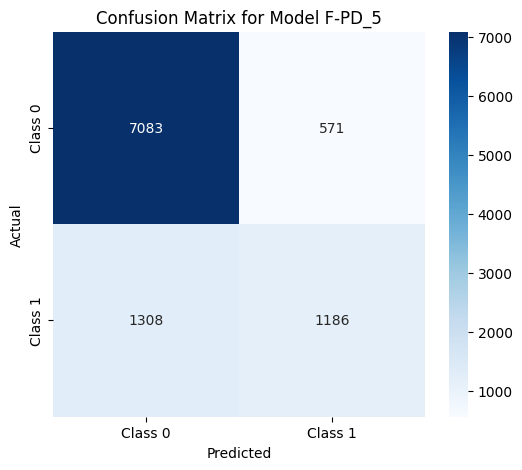


[Info] Testing model W-PD_1 on 10148 samples.
318/318 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
[Info] Model W-PD_1 - Test Accuracy: 0.7662
[Info] Classification Report:
              precision    recall  f1-score   support

     Class 0       0.78      0.95      0.86      7575
     Class 1       0.60      0.23      0.33      2573

    accuracy                           0.77     10148
   macro avg       0.69      0.59      0.60     10148
weighted avg       0.74      0.77      0.73     10148



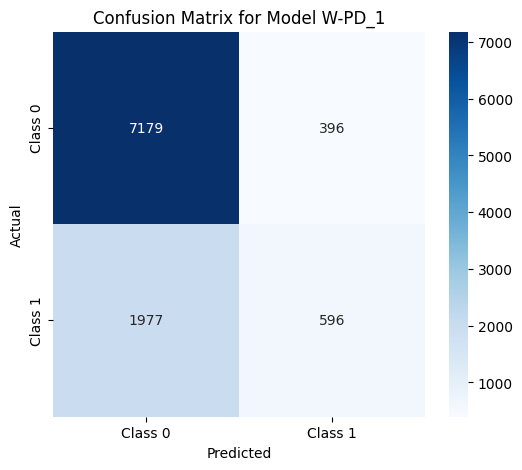


[Info] Testing model W-PD_2 on 10148 samples.
318/318 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
[Info] Model W-PD_2 - Test Accuracy: 0.8069
[Info] Classification Report:
              precision    recall  f1-score   support

     Class 0       0.85      0.91      0.88      7575
     Class 1       0.65      0.51      0.57      2573

    accuracy                           0.81     10148
   macro avg       0.75      0.71      0.72     10148
weighted avg       0.80      0.81      0.80     10148



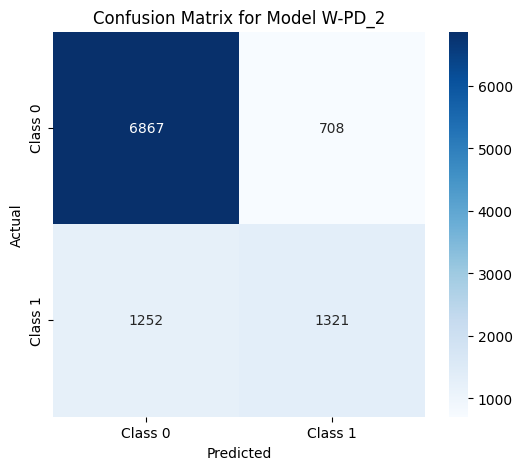


[Info] Testing model W-PD_3 on 10148 samples.
318/318 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
[Info] Model W-PD_3 - Test Accuracy: 0.8542
[Info] Classification Report:
              precision    recall  f1-score   support

     Class 0       0.92      0.89      0.90      7575
     Class 1       0.69      0.76      0.73      2573

    accuracy                           0.85     10148
   macro avg       0.80      0.82      0.81     10148
weighted avg       0.86      0.85      0.86     10148



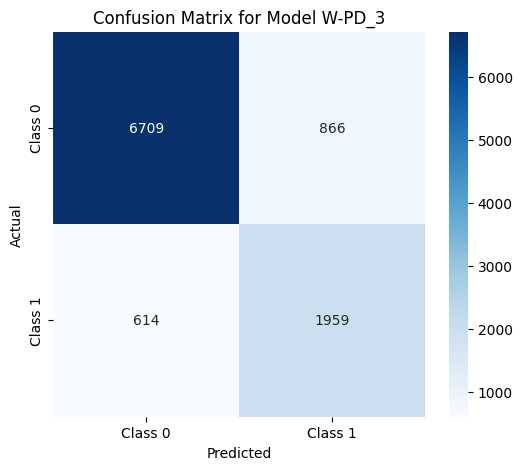


[Info] Testing model W-PD_4 on 10148 samples.
318/318 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
[Info] Model W-PD_4 - Test Accuracy: 0.8891
[Info] Classification Report:
              precision    recall  f1-score   support

     Class 0       0.94      0.91      0.92      7575
     Class 1       0.76      0.82      0.79      2573

    accuracy                           0.89     10148
   macro avg       0.85      0.87      0.86     10148
weighted avg       0.89      0.89      0.89     10148



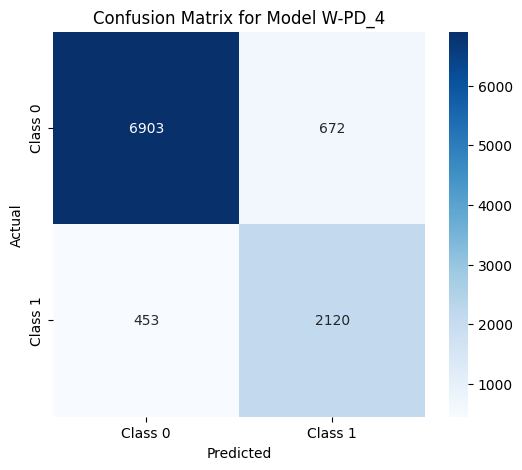


[Info] Testing model W-PD_5 on 10148 samples.
318/318 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
[Info] Model W-PD_5 - Test Accuracy: 0.8970
[Info] Classification Report:
              precision    recall  f1-score   support

     Class 0       0.95      0.91      0.93      7575
     Class 1       0.77      0.86      0.81      2573

    accuracy                           0.90     10148
   macro avg       0.86      0.88      0.87     10148
weighted avg       0.90      0.90      0.90     10148



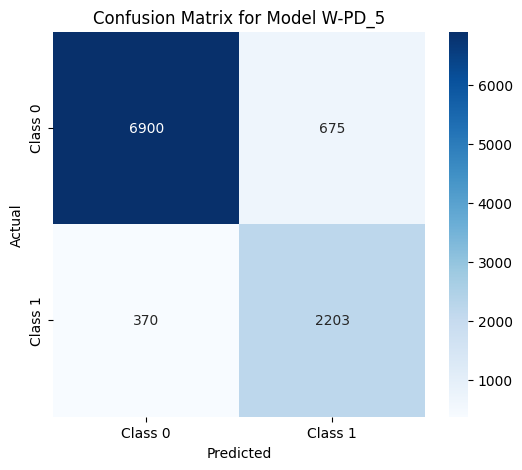

In [36]:
def test_all_models(models, test_data_store):
    """
    Loops through each model in the `models` dictionary and tests it using the corresponding
    test set from `test_data_store`. For each model, it prints accuracy, classification report,
    and plots the confusion matrix.
    """
    for key, model in models.items():
        # Check if test data exists for this model key
        if key not in test_data_store:
            print(f"[Warning] No test data found for model key: {key}. Skipping...")
            continue

        X_test, y_test = test_data_store[key]
        print(f"\n[Info] Testing model {key} on {X_test.shape[0]} samples.")

        # Get model predictions
        y_pred_probs = model.predict(X_test)

        # Determine if the task is binary or multi-class
        unique_labels = np.unique(y_test)
        if len(unique_labels) == 2:
            # Binary classification
            y_pred = (y_pred_probs > 0.5).astype(int).flatten()
            target_names = ['Class 0', 'Class 1']
        else:
            # Multi-class classification: use argmax on the probability output
            y_pred = np.argmax(y_pred_probs, axis=1)
            target_names = ['Withdrawn', 'Fail', 'Pass', 'Distinction']

        # Calculate and print accuracy
        acc = accuracy_score(y_test, y_pred)
        print(f"[Info] Model {key} - Test Accuracy: {acc:.4f}")
        print("[Info] Classification Report:")
        print(classification_report(y_test, y_pred, target_names=target_names))

        # Plot the confusion matrix
        cm = confusion_matrix(y_test, y_pred)
        plt.figure(figsize=(6, 5))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=target_names, yticklabels=target_names)
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title(f"Confusion Matrix for Model {key}")
        plt.show()

# Call the function to test all models
test_all_models(models, test_data_store)

In [37]:
import numpy as np
import random

def test_single_student_each_model(models, test_data_store):
    """
    For each model, randomly select one student from the corresponding test dataset,
    print the student's input data for each segment, and then print the model's prediction
    along with the actual label.
    """
    for key, model in models.items():
        if key not in test_data_store:
            print(f"[Warning] No test data found for model key: {key}. Skipping...")
            continue

        X_test, y_test = test_data_store[key]
        # Randomly select a student sample
        sample_idx = random.randint(0, len(X_test)-1)
        sample_input = X_test[sample_idx]   # shape: (T, F) where T is the number of segments
        actual_label = y_test[sample_idx]

        print(f"\n[Info] Model {key}: Testing a single student sample")
        print("-" * 50)
        print("Student Input Data (each segment):")
        for seg_idx, segment in enumerate(sample_input):
            print(f"Segment {seg_idx}: {segment}")

        # Expand dimensions so that the sample has shape (1, T, F)
        sample_expanded = np.expand_dims(sample_input, axis=0)
        pred_probs = model.predict(sample_expanded)

        # Determine prediction method based on whether the task is binary or multi-class.
        # We check the unique labels in y_test.
        unique_labels = np.unique(y_test)
        if len(unique_labels) == 2:
            # Binary classification
            predicted_label = (pred_probs > 0.5).astype(int).flatten()[0]
        else:
            # Multi-class classification: use argmax
            predicted_label = np.argmax(pred_probs, axis=1)[0]

        print(f"\nActual Label:    {actual_label}")
        print(f"Predicted Label: {predicted_label}")
        print("-" * 50)

# Call the function to test a single student on each model
test_single_student_each_model(models, test_data_store)


[Info] Model 1: Testing a single student sample
--------------------------------------------------
Student Input Data (each segment):
Segment 0: [1.60140407e-02 2.94408896e-02 3.02757890e-04 1.00000000e+00
 1.20000000e+01 3.00000000e+00 1.00000000e+00 2.00000000e+00
 1.93866481e+00 3.21313787e-04]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step

Actual Label:    1
Predicted Label: 1
--------------------------------------------------

[Info] Model 2: Testing a single student sample
--------------------------------------------------
Student Input Data (each segment):
Segment 0: [2.41734803e-02 8.70000000e-01 8.65272938e-02 1.00000000e+00
 4.00000000e+00 1.00000000e+00 5.00000000e+00 1.00000000e+00
 1.00000000e+00 4.29307384e-04]
Segment 1: [1.44566892e-02 7.30000000e-01 4.32636469e-02 1.00000000e+00
 4.00000000e+00 1.00000000e+00 5.00000000e+00 1.00000000e+00
 1.00000000e+00 4.29307384e-04]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step

Actual Label:    2
Predicted Label: 2
------------------------------

In [30]:
acc_list = []
for i in range(1, 6):
    _, (X_test, y_test) = models[i]
    test_acc = models[i].evaluate(X_test, y_test, verbose=0)[1]
    acc_list.append(test_acc)

# Plot accuracy over course progression
plt.plot([20, 40, 60, 80, 100], acc_list, marker='o')
plt.xlabel("Course Progress (%)")
plt.ylabel("Accuracy")
plt.title("Early Prediction Performance Growth")
plt.show()

TypeError: cannot unpack non-iterable Functional object